# IAQF 2026: Cross-Currency Dynamics in Cryptocurrencies under Stablecoin Regulation

## Study Overview
- **Base Asset:** Bitcoin (BTC)
- **Quote Currencies:** USD, USDT, USDC
- **Exchanges:** Binance & Coinbase
- **Data Window:** March 1 â€“ March 21, 2023 (UTC) â€” covers the SVB/USDC de-peg crisis
- **Granularity:** 1-minute candles (most granular available via public APIs)

### Trading Pairs
| Exchange | Pairs |
|----------|-------|
| Binance  | BTC/USDT, BTC/USDC |
| Coinbase | BTC-USD, BTC-USDT, BTC-USDC |

### Key Event Timeline
- **March 8:** Silvergate Bank announces voluntary liquidation
- **March 10:** Silicon Valley Bank (SVB) fails; FDIC takes over; Circle discloses $3.3B USDC reserves stuck at SVB
- **March 11-12:** USDC de-pegs, trading as low as ~$0.87; panic selling across stablecoin markets
- **March 12:** US govt announces all SVB depositors will be made whole
- **March 13:** USDC re-pegs toward $1.00; markets recover

In [28]:
# ============================================================
# Cell 1: Imports & Configuration
# ============================================================
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import datetime, timedelta, timezone
import time
import os
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

# Time window
START_DT = datetime(2023, 3, 1, 0, 0, 0, tzinfo=timezone.utc)
END_DT   = datetime(2023, 3, 21, 23, 59, 0, tzinfo=timezone.utc)

START_MS = int(START_DT.timestamp() * 1000)
END_MS   = int(END_DT.timestamp() * 1000)

DATA_DIR = 'data_sparsh'
os.makedirs(DATA_DIR, exist_ok=True)

print(f"Study window: {START_DT.isoformat()} to {END_DT.isoformat()}")
print(f"Expected 1-min candles per pair: {21 * 24 * 60:,}")

Study window: 2023-03-01T00:00:00+00:00 to 2023-03-21T23:59:00+00:00
Expected 1-min candles per pair: 30,240


---
## 1. Data Collection

We collect **1-minute OHLCV candles** from Binance and Coinbase public REST APIs. This is the most granular candle data available without requiring authenticated websocket feeds.

In [29]:
# ============================================================
# Cell 2: Binance Data Fetcher
# ============================================================

from io import BytesIO
from zipfile import ZipFile

def fetch_binance_vision(symbol: str, interval: str = '1m',
                         start_ms: int = START_MS, end_ms: int = END_MS) -> pd.DataFrame:
    """
    Fetch historical klines from Binance public data (data.binance.vision).
    No geo-restrictions. Downloads monthly CSV zips.
    """
    start_dt_local = pd.Timestamp(start_ms, unit='ms', tz='UTC')
    end_dt_local = pd.Timestamp(end_ms, unit='ms', tz='UTC')

    all_dfs = []
    current = start_dt_local.to_period('M')
    end_period = end_dt_local.to_period('M')

    while current <= end_period:
        year_month = current.strftime('%Y-%m')
        url = (f"https://data.binance.vision/data/spot/monthly/klines/"
               f"{symbol}/{interval}/{symbol}-{interval}-{year_month}.zip")
        print(f"    Downloading {url}")
        resp = requests.get(url, timeout=60)
        if resp.status_code == 404:
            print(f"    WARNING: No data at {url}")
            current += 1
            continue
        resp.raise_for_status()

        with ZipFile(BytesIO(resp.content)) as zf:
            csv_name = zf.namelist()[0]
            df_chunk = pd.read_csv(
                zf.open(csv_name), header=None,
                names=['open_time', 'open', 'high', 'low', 'close', 'volume',
                       'close_time', 'quote_volume', 'trades', 'taker_buy_base',
                       'taker_buy_quote', 'ignore']
            )
            all_dfs.append(df_chunk)
        current += 1

    if not all_dfs:
        print(f"  WARNING: No data from binance.vision for {symbol}")
        return pd.DataFrame()

    df = pd.concat(all_dfs, ignore_index=True)
    df['timestamp'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    for col in ['open', 'high', 'low', 'close', 'volume', 'quote_volume']:
        df[col] = df[col].astype(float)
    df['trades'] = df['trades'].astype(int)
    df = df.set_index('timestamp').sort_index()
    df = df[~df.index.duplicated(keep='first')]
    # Filter to requested window
    df = df[(df.index >= pd.Timestamp(start_ms, unit='ms', tz='UTC')) &
            (df.index <= pd.Timestamp(end_ms, unit='ms', tz='UTC'))]
    print(f"    Got {len(df):,} rows from binance.vision")
    return df

def fetch_binance_klines(symbol: str, interval: str = '1m',
                         start_ms: int = START_MS, end_ms: int = END_MS,
                         limit: int = 1000) -> pd.DataFrame:
    """
    Fetch historical klines (candlestick) data from Binance.
    Paginates automatically in chunks of `limit` candles.

    Note: Binance.com returns HTTP 451 from restricted locations (e.g., US).
    In that case we automatically fall back to Binance US.
    """
    primary_url = 'https://api.binance.com/api/v3/klines'
    fallback_url = 'https://api.binance.us/api/v3/klines'
    url = primary_url
    used_fallback = False

    all_data = []
    current_start = start_ms

    while current_start < end_ms:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_ms,
            'limit': limit
        }
        resp = requests.get(url, params=params, timeout=30)

        if resp.status_code == 451 and not used_fallback:
            print("  Binance.com blocked (451). Switching to binance.us for data.")
            url = fallback_url
            used_fallback = True
            continue
        if resp.status_code == 429:
            print(f"  Rate limited on {symbol}, sleeping 60s...")
            time.sleep(60)
            continue
        if resp.status_code == 400 and used_fallback:
            print(f"  Binance.us returned 400 for {symbol}. Falling back to data.binance.vision ...")
            return fetch_binance_vision(symbol, interval, start_ms, end_ms)

        resp.raise_for_status()
        data = resp.json()
        if not data:
            break
        all_data.extend(data)
        # Next start = close_time of last candle + 1ms
        current_start = data[-1][6] + 1
        time.sleep(0.15)  # respect rate limits

    if not all_data:
        print(f"  WARNING: No data returned for Binance {symbol}")
        return pd.DataFrame()

    df = pd.DataFrame(all_data, columns=[
        'open_time', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    df['timestamp'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    for col in ['open', 'high', 'low', 'close', 'volume', 'quote_volume']:
        df[col] = df[col].astype(float)
    df['trades'] = df['trades'].astype(int)
    df = df.set_index('timestamp')
    df = df[~df.index.duplicated(keep='first')]
    return df

print("Binance fetcher ready.")


Binance fetcher ready.


In [30]:
# ============================================================
# Cell 3: Coinbase Data Fetcher
# ============================================================

def fetch_coinbase_candles(product_id: str, granularity: int = 60,
                           start_dt: datetime = START_DT,
                           end_dt: datetime = END_DT) -> pd.DataFrame:
    """
    Fetch historical candles from Coinbase Advanced Trade Market Data API.
    Max ~350 candles per request; paginates automatically.
    granularity is in seconds (60 = 1 minute).
    """
    url = f'https://api.coinbase.com/api/v3/brokerage/market/products/{product_id}/candles'

    gran_map = {
        60: 'ONE_MINUTE',
        300: 'FIVE_MINUTE',
        900: 'FIFTEEN_MINUTE',
        3600: 'ONE_HOUR',
        21600: 'SIX_HOUR',
        86400: 'ONE_DAY',
    }
    if granularity not in gran_map:
        raise ValueError("Unsupported granularity. Use 60, 300, 900, 3600, 21600, or 86400 seconds.")
    granularity_str = gran_map[granularity]

    all_data = []
    # Coinbase limit: < 350 candles per request. Use 300 to be safe.
    chunk_seconds = 300 * granularity
    current_start = start_dt

    while current_start < end_dt:
        current_end = min(current_start + timedelta(seconds=chunk_seconds), end_dt)
        params = {
            'granularity': granularity_str,
            'start': int(current_start.timestamp()),
            'end': int(current_end.timestamp())
        }
        resp = requests.get(url, params=params, timeout=30)
        if resp.status_code == 429:
            print(f"  Rate limited on {product_id}, sleeping 5s...")
            time.sleep(5)
            continue
        if resp.status_code == 404:
            print(f"  WARNING: Product {product_id} not found on Coinbase Advanced Trade")
            return pd.DataFrame()
        resp.raise_for_status()
        data = resp.json().get('candles', [])
        if data:
            all_data.extend(data)
        current_start = current_end
        time.sleep(0.2)  # respect rate limits

    if not all_data:
        print(f"  WARNING: No data returned for Coinbase {product_id}")
        return pd.DataFrame()

    # Coinbase returns: start, low, high, open, close, volume (as strings)
    df = pd.DataFrame(all_data)
    if df.empty:
        return df

    df['timestamp'] = pd.to_datetime(df['start'].astype(int), unit='s', utc=True)
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = df[col].astype(float)

    df = df.set_index('timestamp').sort_index()
    df = df[~df.index.duplicated(keep='first')]
    return df

print("Coinbase fetcher ready.")


Coinbase fetcher ready.


In [31]:
# ============================================================
# Cell 4: Kraken Data Fetcher (from raw trades -> 1-min OHLCV)
# ============================================================

def fetch_kraken_ohlcv(pair: str,
                       start_dt: datetime = START_DT,
                       end_dt: datetime = END_DT) -> pd.DataFrame:
    """
    Fetch historical 1-min OHLCV from Kraken by paginating raw trades
    and aggregating into 1-minute candles.

    Kraken's OHLC endpoint only returns the last 720 candles, so
    we use the Trades endpoint which supports full history via the
    'since' parameter (nanosecond timestamp).

    pair: Kraken pair name, e.g. 'XXBTZEUR', 'XXBTZUSD', 'XBTUSDT', 'XBTUSDC'
    """
    url = 'https://api.kraken.com/0/public/Trades'
    since_ns = int(start_dt.timestamp() * 1e9)
    end_ts = end_dt.timestamp()

    all_trades = []
    call_count = 0

    while True:
        params = {'pair': pair, 'since': str(since_ns)}
        resp = requests.get(url, params=params, timeout=30)

        if resp.status_code == 429:
            print(f"  Rate limited on {pair}, sleeping 10s...")
            time.sleep(10)
            continue

        resp.raise_for_status()
        data = resp.json()

        if data.get('error'):
            print(f"  Kraken API error for {pair}: {data['error']}")
            break

        result = data['result']
        new_since = int(result['last'])
        trade_key = [k for k in result if k != 'last'][0]
        trades = result[trade_key]

        if not trades or new_since == since_ns:
            break

        all_trades.extend(trades)
        since_ns = new_since
        call_count += 1

        last_trade_ts = float(trades[-1][2])
        if last_trade_ts >= end_ts:
            break

        if call_count % 100 == 0:
            pct = (last_trade_ts - start_dt.timestamp()) / (end_dt.timestamp() - start_dt.timestamp()) * 100
            print(f"    {pair}: {call_count} calls, {pct:.0f}% done...")

        # Kraken public API: counter limit=15, decay=1/sec. Burst then pace.
        if call_count % 14 == 0:
            time.sleep(3)
        else:
            time.sleep(0.1)

    if not all_trades:
        print(f"  WARNING: No trades returned for Kraken {pair}")
        return pd.DataFrame()

    print(f"  Fetched {len(all_trades):,} trades in {call_count} API calls for {pair}")

    # Build DataFrame from trades: [price, volume, time, buy/sell, market/limit, misc, trade_id]
    df_trades = pd.DataFrame(all_trades, columns=['price', 'volume', 'time', 'side', 'type', 'misc', 'trade_id'])
    df_trades['price'] = df_trades['price'].astype(float)
    df_trades['volume'] = df_trades['volume'].astype(float)
    df_trades['timestamp'] = pd.to_datetime(df_trades['time'].astype(float), unit='s', utc=True)

    # Filter to study window
    df_trades = df_trades[(df_trades['timestamp'] >= start_dt) & (df_trades['timestamp'] <= end_dt)]

    # Resample to 1-minute OHLCV
    df_trades = df_trades.set_index('timestamp')
    ohlcv = df_trades['price'].resample('1min').ohlc()
    ohlcv['volume'] = df_trades['volume'].resample('1min').sum()
    ohlcv['trades'] = df_trades['price'].resample('1min').count()
    ohlcv = ohlcv.dropna(subset=['close'])

    print(f"  Built {len(ohlcv):,} 1-min candles for {pair}")
    return ohlcv

print("Kraken fetcher ready.")


Kraken fetcher ready.


In [32]:
# ============================================================
# Cell 5: Fetch ALL data (with caching)
# ============================================================

def cache_path(name: str) -> str:
    return os.path.join(DATA_DIR, f"{name}.parquet")

def load_or_fetch(name: str, fetch_fn, *args, **kwargs) -> pd.DataFrame:
    """Load from cache if available, otherwise fetch and cache."""
    path = cache_path(name)
    if os.path.exists(path):
        print(f"  Loading cached: {name}")
        df = pd.read_parquet(path)
        if not isinstance(df.index, pd.DatetimeIndex):
            if 'timestamp' in df.columns:
                df = df.set_index('timestamp')
        return df
    print(f"  Fetching: {name} ...")
    df = fetch_fn(*args, **kwargs)
    if not df.empty:
        df.to_parquet(path)
        print(f"  Saved {len(df):,} rows -> {path}")
    return df

# ----- Binance Pairs -----
print("=" * 60)
print("BINANCE")
print("=" * 60)

binance_btcusdt = load_or_fetch(
    'binance_btcusdt',
    fetch_binance_klines, 'BTCUSDT'
)

binance_btcusdc = load_or_fetch(
    'binance_btcusdc',
    fetch_binance_klines, 'BTCUSDC'
)

binance_btceur = load_or_fetch(
    'binance_btceur',
    fetch_binance_klines, 'BTCEUR'
)

# ----- Coinbase Pairs -----
print("\n" + "=" * 60)
print("COINBASE")
print("=" * 60)

coinbase_btcusd = load_or_fetch(
    'coinbase_btcusd',
    fetch_coinbase_candles, 'BTC-USD'
)

coinbase_btcusdt = load_or_fetch(
    'coinbase_btcusdt',
    fetch_coinbase_candles, 'BTC-USDT'
)

coinbase_btceur = load_or_fetch(
    'coinbase_btceur',
    fetch_coinbase_candles, 'BTC-EUR'
)

# NOTE: Coinbase BTC-USDC is an alias for BTC-USD (same order book), not fetched separately

# ----- Kraken Pairs -----
print("\n" + "=" * 60)
print("KRAKEN")
print("=" * 60)

kraken_btcusd = load_or_fetch(
    'kraken_btcusd',
    fetch_kraken_ohlcv, 'XXBTZUSD'
)

kraken_btcusdt = load_or_fetch(
    'kraken_btcusdt',
    fetch_kraken_ohlcv, 'XBTUSDT'
)

kraken_btcusdc = load_or_fetch(
    'kraken_btcusdc',
    fetch_kraken_ohlcv, 'XBTUSDC'
)

kraken_btceur = load_or_fetch(
    'kraken_btceur',
    fetch_kraken_ohlcv, 'XXBTZEUR'
)

# ----- Summary -----
print("\n" + "=" * 60)
print("DATA SUMMARY")
print("=" * 60)
datasets = {
    'Binance BTC/USDT': binance_btcusdt,
    'Binance BTC/USDC': binance_btcusdc,
    'Binance BTC/EUR': binance_btceur,
    'Coinbase BTC/USD': coinbase_btcusd,
    'Coinbase BTC/USDT': coinbase_btcusdt,
    'Coinbase BTC/EUR': coinbase_btceur,
    'Kraken BTC/USD': kraken_btcusd,
    'Kraken BTC/USDT': kraken_btcusdt,
    'Kraken BTC/USDC': kraken_btcusdc,
    'Kraken BTC/EUR': kraken_btceur,
}
for name, df in datasets.items():
    if df.empty:
        print(f"  {name:30s} -> NO DATA")
    else:
        print(f"  {name:30s} -> {len(df):>8,} rows  |  {df.index.min()} to {df.index.max()}")


BINANCE
  Loading cached: binance_btcusdt
  Loading cached: binance_btcusdc
  Loading cached: binance_btceur

COINBASE
  Loading cached: coinbase_btcusd
  Loading cached: coinbase_btcusdt
  Loading cached: coinbase_btceur

KRAKEN
  Loading cached: kraken_btcusd
  Loading cached: kraken_btcusdt
  Loading cached: kraken_btcusdc
  Loading cached: kraken_btceur

DATA SUMMARY
  Binance BTC/USDT               ->   30,240 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:59:00+00:00
  Binance BTC/USDC               ->   30,240 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:59:00+00:00
  Binance BTC/EUR                ->   30,240 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:59:00+00:00
  Coinbase BTC/USD               ->   29,950 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:59:00+00:00
  Coinbase BTC/USDT              ->   24,478 rows  |  2023-03-01 00:00:00+00:00 to 2023-03-21 23:58:00+00:00
  Coinbase BTC/EUR               ->   27,261 rows  |  2023-03-01 00:00:00+00:00 t

---
## 2. Data Description & Preprocessing

We align all datasets to a common 1-minute timestamp grid and compute derived fields.

In [33]:
# ============================================================
# Cell 6: Build a unified close-price panel
# ============================================================

# Create a common minute-level index
full_index = pd.date_range(START_DT, END_DT, freq='1min', tz='UTC')

def extract_close(df: pd.DataFrame, idx: pd.DatetimeIndex) -> pd.Series:
    """Extract close prices reindexed to common grid."""
    if df.empty:
        return pd.Series(np.nan, index=idx, dtype=float)
    s = df['close'].reindex(idx)
    return s

def extract_volume(df: pd.DataFrame, idx: pd.DatetimeIndex) -> pd.Series:
    if df.empty:
        return pd.Series(0.0, index=idx, dtype=float)
    s = df['volume'].reindex(idx, fill_value=0.0)
    return s

def extract_trades(df: pd.DataFrame, idx: pd.DatetimeIndex) -> pd.Series:
    if df.empty or 'trades' not in df.columns:
        return pd.Series(0, index=idx, dtype=int)
    s = df['trades'].reindex(idx, fill_value=0)
    return s

def extract_spread_proxy(df: pd.DataFrame, idx: pd.DatetimeIndex) -> pd.Series:
    """Use (high - low) as a proxy for the intra-candle spread."""
    if df.empty:
        return pd.Series(np.nan, index=idx, dtype=float)
    s = (df['high'] - df['low']).reindex(idx)
    return s

# Close prices panel
closes = pd.DataFrame({
    'binance_btcusdt': extract_close(binance_btcusdt, full_index),
    'binance_btcusdc': extract_close(binance_btcusdc, full_index),
    'binance_btceur': extract_close(binance_btceur, full_index),
    'coinbase_btcusd': extract_close(coinbase_btcusd, full_index),
    'coinbase_btcusdt': extract_close(coinbase_btcusdt, full_index),
    'coinbase_btceur': extract_close(coinbase_btceur, full_index),
    'kraken_btcusd': extract_close(kraken_btcusd, full_index),
    'kraken_btcusdt': extract_close(kraken_btcusdt, full_index),
    'kraken_btcusdc': extract_close(kraken_btcusdc, full_index),
    'kraken_btceur': extract_close(kraken_btceur, full_index),
}, index=full_index)

# Volume panel
volumes = pd.DataFrame({
    'binance_btcusdt': extract_volume(binance_btcusdt, full_index),
    'binance_btcusdc': extract_volume(binance_btcusdc, full_index),
    'binance_btceur': extract_volume(binance_btceur, full_index),
    'coinbase_btcusd': extract_volume(coinbase_btcusd, full_index),
    'coinbase_btcusdt': extract_volume(coinbase_btcusdt, full_index),
    'coinbase_btceur': extract_volume(coinbase_btceur, full_index),
    'kraken_btcusd': extract_volume(kraken_btcusd, full_index),
    'kraken_btcusdt': extract_volume(kraken_btcusdt, full_index),
    'kraken_btcusdc': extract_volume(kraken_btcusdc, full_index),
    'kraken_btceur': extract_volume(kraken_btceur, full_index),
}, index=full_index)

# Spread proxy panel
spreads = pd.DataFrame({
    'binance_btcusdt': extract_spread_proxy(binance_btcusdt, full_index),
    'binance_btcusdc': extract_spread_proxy(binance_btcusdc, full_index),
    'binance_btceur': extract_spread_proxy(binance_btceur, full_index),
    'coinbase_btcusd': extract_spread_proxy(coinbase_btcusd, full_index),
    'coinbase_btcusdt': extract_spread_proxy(coinbase_btcusdt, full_index),
    'coinbase_btceur': extract_spread_proxy(coinbase_btceur, full_index),
    'kraken_btcusd': extract_spread_proxy(kraken_btcusd, full_index),
    'kraken_btcusdt': extract_spread_proxy(kraken_btcusdt, full_index),
    'kraken_btcusdc': extract_spread_proxy(kraken_btcusdc, full_index),
    'kraken_btceur': extract_spread_proxy(kraken_btceur, full_index),
}, index=full_index)

# Trade count panel (Binance and Kraken provide trade counts)
trade_counts = pd.DataFrame({
    'binance_btcusdt': extract_trades(binance_btcusdt, full_index),
    'binance_btcusdc': extract_trades(binance_btcusdc, full_index),
    'binance_btceur': extract_trades(binance_btceur, full_index),
    'kraken_btcusd': extract_trades(kraken_btcusd, full_index),
    'kraken_btcusdt': extract_trades(kraken_btcusdt, full_index),
    'kraken_btcusdc': extract_trades(kraken_btcusdc, full_index),
    'kraken_btceur': extract_trades(kraken_btceur, full_index),
}, index=full_index)

# Forward-fill small gaps (max 5 minutes) for close prices
closes = closes.ffill(limit=5)

# Data coverage report
print("Close price coverage (% non-NaN):")
print((closes.notna().mean() * 100).round(2).to_string())
print(f"\nTotal minutes in window: {len(full_index):,}")


Close price coverage (% non-NaN):
binance_btcusdt     100.00
binance_btcusdc     100.00
binance_btceur      100.00
coinbase_btcusd      99.10
coinbase_btcusdt     98.93
coinbase_btceur      98.89
kraken_btcusd        99.98
kraken_btcusdt       98.44
kraken_btcusdc       94.05
kraken_btceur        99.98

Total minutes in window: 30,240


In [34]:
# ============================================================
# Cell 7: Compute implied stablecoin exchange rates from BTC triangulation
# ============================================================

def aligned_ratio(numer: pd.Series, denom: pd.Series, idx: pd.DatetimeIndex) -> pd.Series:
    """Compute numer/denom on overlapping timestamps only, then reindex."""
    pair = pd.concat([numer, denom], axis=1).dropna()
    if pair.empty:
        return pd.Series(np.nan, index=idx, dtype=float)
    ratio = pair.iloc[:, 0] / pair.iloc[:, 1]
    return ratio.reindex(idx)

# --- Coinbase (has btcusd, btcusdt, btceur — no btcusdc) ---

# Implied USDT/USD = BTC_USD / BTC_USDT (from Coinbase)
closes['implied_usdt_usd_coinbase'] = aligned_ratio(
    closes['coinbase_btcusd'],
    closes['coinbase_btcusdt'],
    closes.index
)

# Implied EUR/USD = BTC_USD / BTC_EUR (from Coinbase)
closes['implied_eur_usd_coinbase'] = aligned_ratio(
    closes['coinbase_btcusd'],
    closes['coinbase_btceur'],
    closes.index
)

# --- Binance (has btcusdt, btcusdc, btceur — no btcusd) ---

# Implied USDT/USDC = BTC_USDC / BTC_USDT (from Binance)
closes['implied_usdt_usdc_binance'] = aligned_ratio(
    closes['binance_btcusdc'],
    closes['binance_btcusdt'],
    closes.index
)

# Implied EUR/USDT = BTC_USDT / BTC_EUR (from Binance)
closes['implied_eur_usdt_binance'] = aligned_ratio(
    closes['binance_btcusdt'],
    closes['binance_btceur'],
    closes.index
)

# --- Kraken (has btcusd, btcusdt, btcusdc, btceur) ---

# Implied USDT/USD = BTC_USD / BTC_USDT (from Kraken)
closes['implied_usdt_usd_kraken'] = aligned_ratio(
    closes['kraken_btcusd'],
    closes['kraken_btcusdt'],
    closes.index
)

# Implied USDC/USD = BTC_USD / BTC_USDC (from Kraken)
closes['implied_usdc_usd_kraken'] = aligned_ratio(
    closes['kraken_btcusd'],
    closes['kraken_btcusdc'],
    closes.index
)

# Implied USDT/USDC = BTC_USDC / BTC_USDT (from Kraken)
closes['implied_usdt_usdc_kraken'] = aligned_ratio(
    closes['kraken_btcusdc'],
    closes['kraken_btcusdt'],
    closes.index
)

# Implied EUR/USD = BTC_USD / BTC_EUR (from Kraken)
closes['implied_eur_usd_kraken'] = aligned_ratio(
    closes['kraken_btcusd'],
    closes['kraken_btceur'],
    closes.index
)

# Quick sanity check
print("Implied stablecoin rates (mean over full window):")
for col in [
    'implied_usdt_usd_coinbase',
    'implied_eur_usd_coinbase',
    'implied_usdt_usdc_binance',
    'implied_eur_usdt_binance',
    'implied_usdt_usd_kraken',
    'implied_usdc_usd_kraken',
    'implied_usdt_usdc_kraken',
    'implied_eur_usd_kraken',
]:
    if closes[col].notna().any():
        print(f"  {col}: {closes[col].mean():.6f}")

Implied stablecoin rates (mean over full window):
  implied_usdt_usd_coinbase: 1.002381
  implied_eur_usd_coinbase: 1.066541
  implied_usdt_usdc_binance: 1.007177
  implied_eur_usdt_binance: 1.059740
  implied_usdt_usd_kraken: 1.002163
  implied_usdc_usd_kraken: 0.994805
  implied_usdt_usdc_kraken: 1.007867
  implied_eur_usd_kraken: 1.067578


In [35]:
# ============================================================
# Cell 8: Summary statistics table
# ============================================================

btc_cols = [
    'binance_btcusdt', 'binance_btcusdc', 'binance_btceur',
    'coinbase_btcusd', 'coinbase_btcusdt', 'coinbase_btceur',
    'kraken_btcusd', 'kraken_btcusdt', 'kraken_btcusdc', 'kraken_btceur',
]
nice_names = [
    'Binance BTC/USDT', 'Binance BTC/USDC', 'Binance BTC/EUR',
    'Coinbase BTC/USD', 'Coinbase BTC/USDT', 'Coinbase BTC/EUR',
    'Kraken BTC/USD', 'Kraken BTC/USDT', 'Kraken BTC/USDC', 'Kraken BTC/EUR',
]

# 1-min returns
returns = closes[btc_cols].pct_change()

stats = pd.DataFrame({
    'Mean Price': closes[btc_cols].mean(),
    'Std Price': closes[btc_cols].std(),
    'Min Price': closes[btc_cols].min(),
    'Max Price': closes[btc_cols].max(),
    'Mean 1m Return (bps)': returns[btc_cols].mean() * 1e4,
    'Std 1m Return (bps)': returns[btc_cols].std() * 1e4,
    'Mean Volume (BTC)': volumes[btc_cols].mean(),
    'Total Volume (BTC)': volumes[btc_cols].sum(),
    'Mean Spread Proxy ($)': spreads[btc_cols].mean(),
    'Coverage (%)': closes[btc_cols].notna().mean() * 100,
})
stats.index = nice_names
stats.round(4)


,Mean Price,Std Price,Min Price,Max Price,Mean 1m Return (bps),Std 1m Return (bps),Mean Volume (BTC),Total Volume (BTC),Mean Spread Proxy ($),Coverage (%)
Binance BTC/USDT,23668.1482,2460.8089,19597.03,28447.50,0.0684,9.0310,2.0624,62367.5220,21.9332,100.0000
Binance BTC/USDC,23822.9354,2372.0048,19588.23,28548.74,0.0712,11.1634,0.1279,3868.7708,10.5678,100.0000
Binance BTC/EUR,22331.6677,2292.3280,18618.00,26850.00,0.0614,8.8220,2.7994,84653.6854,25.8832,100.0000
Coinbase BTC/USD,23737.3010,2479.5992,19597.52,28550.00,0.0695,9.1073,14.0856,425948.8739,26.7038,99.1005
Coinbase BTC/USDT,23683.0542,2469.3791,19594.77,28445.00,0.0688,9.2938,0.6036,18253.2017,19.9835,98.9253
Coinbase BTC/EUR,22254.8480,2275.1294,18485.63,26765.15,0.0629,8.8750,0.5115,15467.6184,18.2708,98.8922
Kraken BTC/USD,23718.2154,2465.9418,19583.50,28546.40,0.0691,8.9709,4.3415,131287.7660,18.9773,99.9769
Kraken BTC/USDT,23670.0092,2466.6679,19588.10,28418.50,0.0689,9.1893,0.3938,11909.6834,12.2419,98.4392
Kraken BTC/USDC,23851.4597,2390.9089,19588.84,28548.18,0.0731,12.3067,0.3009,9098.4416,20.2938,94.0509
Kraken BTC/EUR,22214.8849,2279.2906,18480.10,26753.90,0.0630,8.8518,1.3704,41441.4179,17.7500,99.9769


---
## 3. Cross-Currency Basis Analysis

The **cross-currency basis** measures the price difference of BTC quoted in one currency versus another, after accounting for the exchange rate between those currencies.

For BTC/USDT vs BTC/USD, the basis (in bps) is:

$$\text{Basis}_{\text{USDT}} = \left(\frac{P_{\text{BTC/USD}}}{P_{\text{BTC/USDT}}} - 1\right) \times 10000$$

A positive basis means BTC is cheaper in USDT terms (USDT trades at a premium to USD); a negative basis means BTC is more expensive in USDT (USDT at a discount).

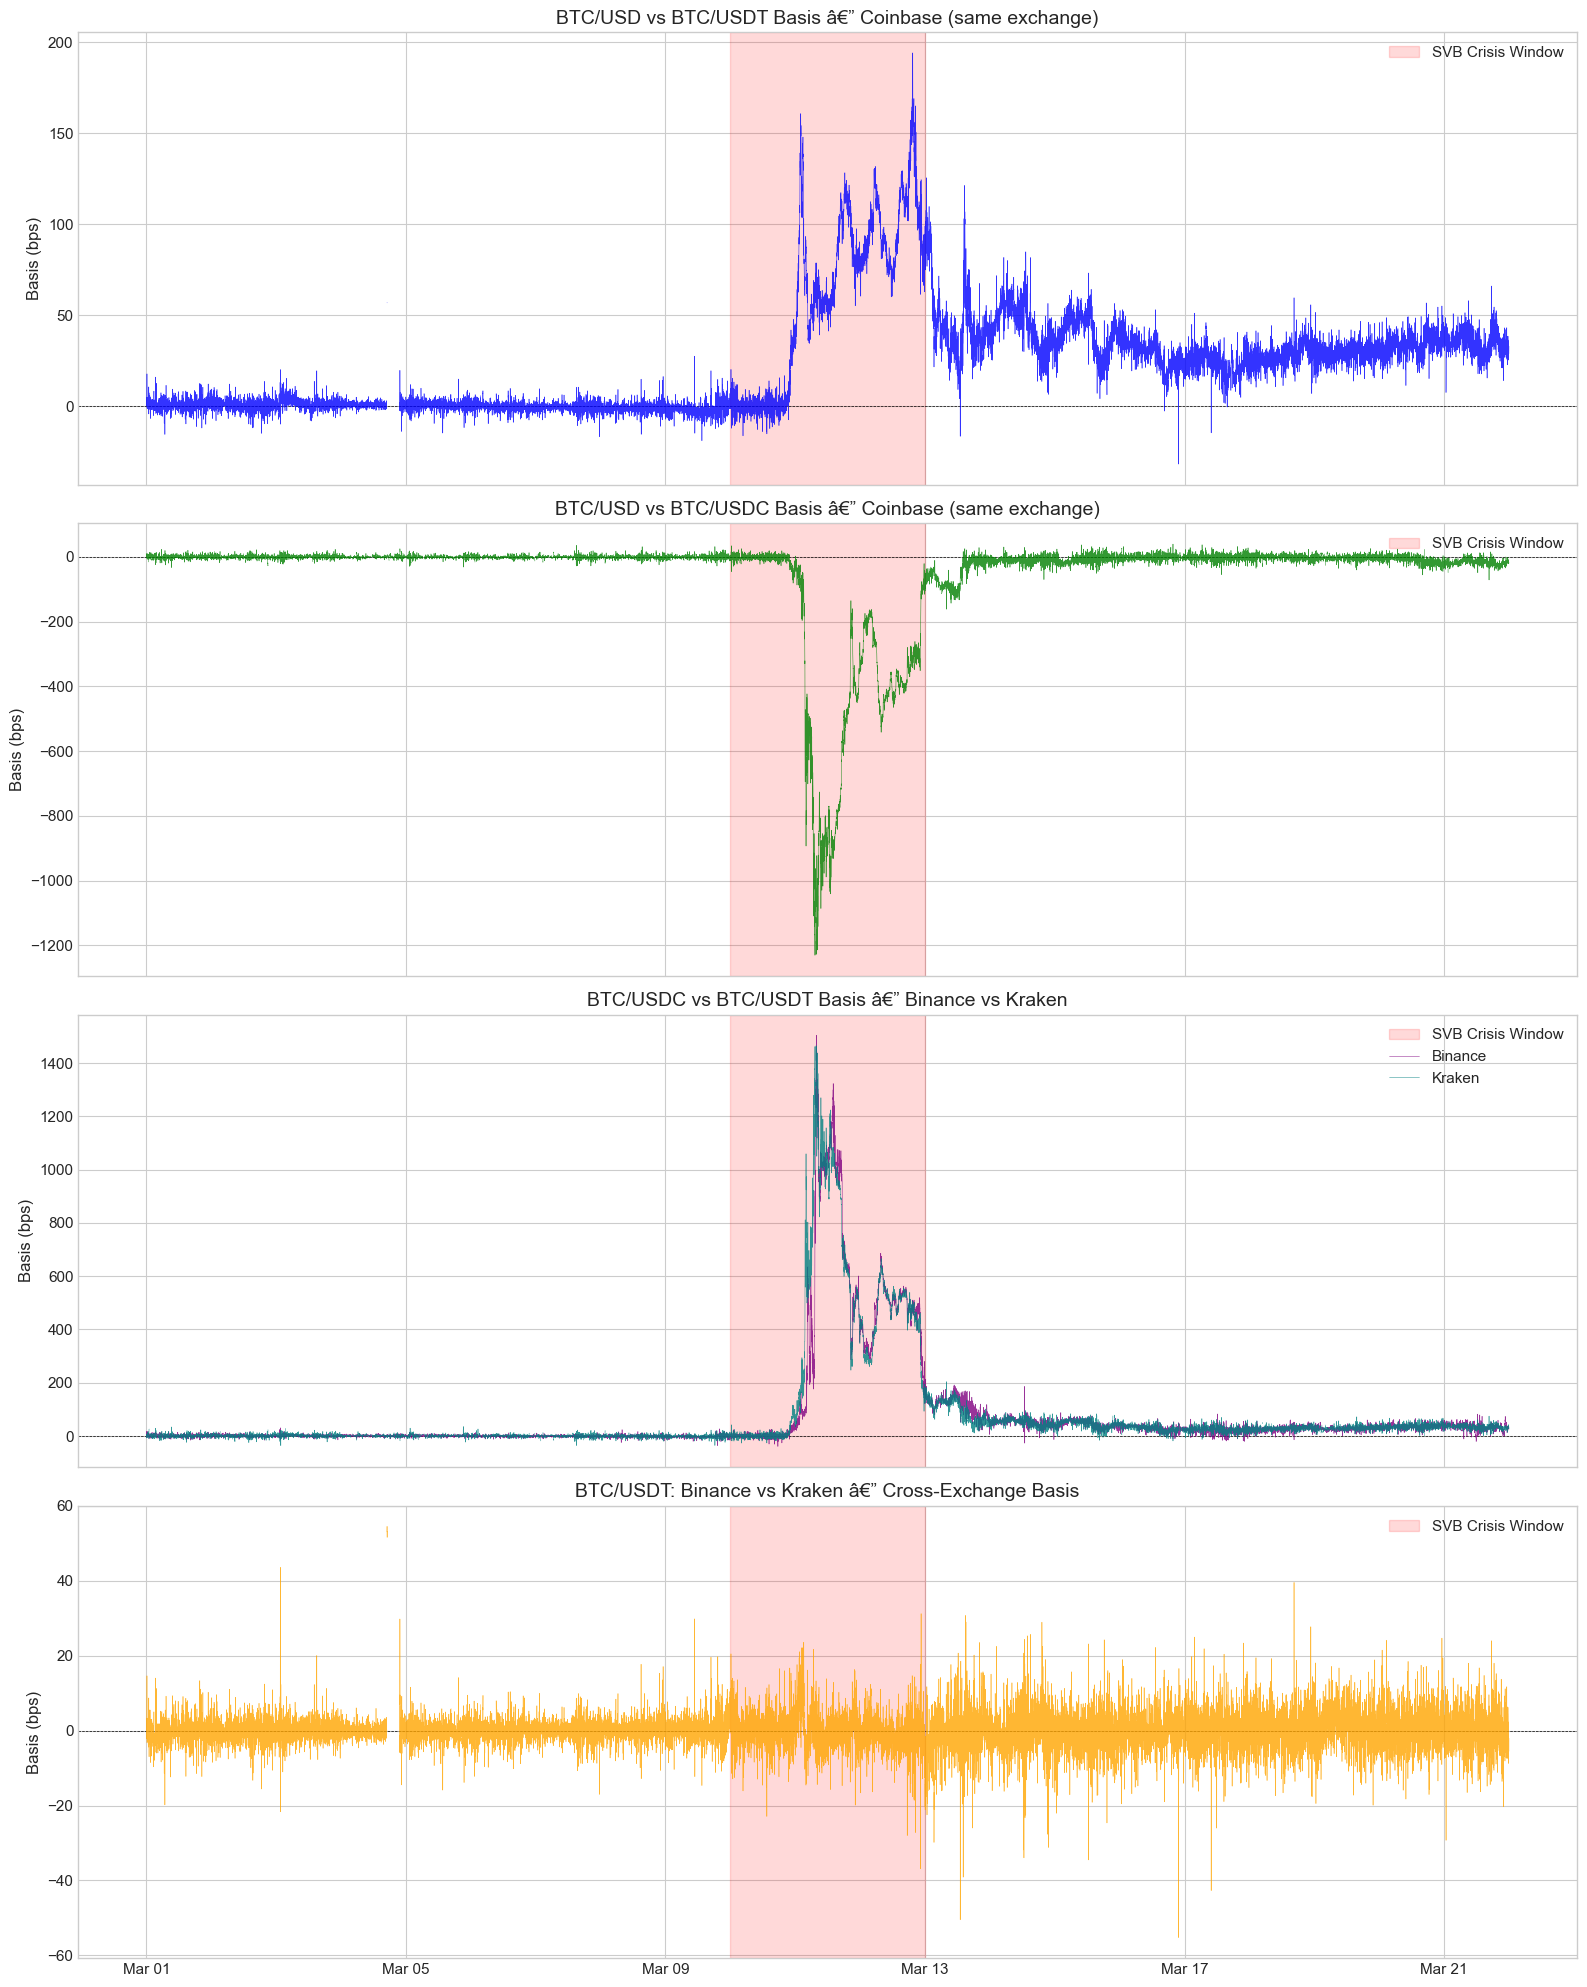

Figure saved: fig_cross_currency_basis.png


In [36]:
# ============================================================
# Cell 9: Cross-currency basis â€” same exchange (Coinbase)
# ============================================================

# Basis: BTC/USD vs BTC/USDT on Coinbase
basis_usdt_coinbase = (closes['implied_usdt_usd_coinbase'] - 1) * 1e4
basis_usdt_coinbase.name = 'USDT basis (bps) [Coinbase]'

# Basis: BTC/USD vs BTC/USDC on Coinbase
basis_usdc_kraken = (closes['implied_usdc_usd_kraken'] - 1) * 1e4
basis_usdc_kraken.name = 'USDC basis (bps) [Kraken]'

# Basis: BTC/USDT vs BTC/USDC on Binance
basis_usdt_usdc_binance = (closes['implied_usdt_usdc_binance'] - 1) * 1e4
basis_usdt_usdc_binance.name = 'USDT/USDC basis (bps) [Binance]'

# Basis: BTC/USDT vs BTC/USDC on Coinbase
basis_usdt_usdc_kraken = (closes['implied_usdt_usdc_kraken'] - 1) * 1e4
basis_usdt_usdc_kraken.name = 'USDT/USDC basis (bps) [Kraken]'

# Cross-exchange basis: Binance BTC/USDT vs Coinbase BTC/USDT
basis_cross_exchange = (closes['binance_btcusdt'] / closes['coinbase_btcusdt'] - 1) * 1e4
basis_cross_exchange.name = 'Binance vs Kraken BTC/USDT (bps)'

fig, axes = plt.subplots(4, 1, figsize=(16, 20), sharex=True)

# SVB event shading
svb_start = pd.Timestamp('2023-03-10', tz='UTC')
svb_end = pd.Timestamp('2023-03-13', tz='UTC')

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis Window')
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')

axes[0].plot(basis_usdt_coinbase.index, basis_usdt_coinbase, linewidth=0.4, alpha=0.8, color='blue')
axes[0].set_title('BTC/USD vs BTC/USDT Basis â€” Coinbase (same exchange)')
axes[0].set_ylabel('Basis (bps)')

axes[1].plot(basis_usdc_kraken.index, basis_usdc_kraken, linewidth=0.4, alpha=0.8, color='green')
axes[1].set_title('BTC/USD vs BTC/USDC Basis â€” Coinbase (same exchange)')
axes[1].set_ylabel('Basis (bps)')

axes[2].plot(basis_usdt_usdc_binance.index, basis_usdt_usdc_binance, linewidth=0.4, alpha=0.8, color='purple', label='Binance')
axes[2].plot(basis_usdt_usdc_kraken.index, basis_usdt_usdc_kraken, linewidth=0.4, alpha=0.8, color='teal', label='Kraken')
axes[2].set_title('BTC/USDC vs BTC/USDT Basis â€” Binance vs Kraken')
axes[2].set_ylabel('Basis (bps)')

axes[3].plot(basis_cross_exchange.index, basis_cross_exchange, linewidth=0.4, alpha=0.8, color='orange')
axes[3].set_title('BTC/USDT: Binance vs Kraken â€” Cross-Exchange Basis')
axes[3].set_ylabel('Basis (bps)')

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('fig_cross_currency_basis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved: fig_cross_currency_basis.png")


In [37]:
# ============================================================
# Cell 10: Basis statistics by regime (pre-crisis, crisis, post-crisis)
# ============================================================

regimes = {
    'Pre-SVB (Mar 1-9)': (pd.Timestamp('2023-03-01', tz='UTC'), pd.Timestamp('2023-03-10', tz='UTC')),
    'SVB Crisis (Mar 10-13)': (pd.Timestamp('2023-03-10', tz='UTC'), pd.Timestamp('2023-03-14', tz='UTC')),
    'Post-SVB (Mar 14-21)': (pd.Timestamp('2023-03-14', tz='UTC'), pd.Timestamp('2023-03-22', tz='UTC')),
}

basis_series = {
    'USDT basis (Coinbase)': basis_usdt_coinbase,
    'USDC basis (Kraken)': basis_usdc_kraken,
    'USDT/USDC basis (Binance)': basis_usdt_usdc_binance,
    'USDT/USDC basis (Kraken)': basis_usdt_usdc_kraken,
    'Cross-exch BTC/USDT': basis_cross_exchange,
}

regime_stats = []
for regime_name, (t0, t1) in regimes.items():
    for basis_name, bs in basis_series.items():
        subset = bs[(bs.index >= t0) & (bs.index < t1)].dropna()
        regime_stats.append({
            'Regime': regime_name,
            'Basis': basis_name,
            'Mean (bps)': subset.mean(),
            'Std (bps)': subset.std(),
            'Min (bps)': subset.min(),
            'Max (bps)': subset.max(),
            'Median (bps)': subset.median(),
            'Skewness': subset.skew(),
            'Kurtosis': subset.kurtosis(),
            'N obs': len(subset),
        })

regime_df = pd.DataFrame(regime_stats)
regime_df.set_index(['Regime', 'Basis'], inplace=True)
regime_df.round(2)


Mean (bps)  Std (bps)  \
Regime                 Basis                                              
Pre-SVB (Mar 1-9)      USDT basis (Coinbase)            0.28       2.95   
                       USDC basis (Kraken)             -0.12       4.95   
                       USDT/USDC basis (Binance)        0.32       3.83   
                       USDT/USDC basis (Kraken)         0.68       5.09   
                       Cross-exch BTC/USDT              0.01       2.82   
SVB Crisis (Mar 10-13) USDT basis (Coinbase)           57.13      42.13   
                       USDC basis (Kraken)           -245.51     290.58   
                       USDT/USDC basis (Binance)      308.08     332.80   
                       USDT/USDC basis (Kraken)       317.84     338.64   
                       Cross-exch BTC/USDT             -0.33       5.11   
Post-SVB (Mar 14-21)   USDT basis (Coinbase)           32.97       9.93   
                       USDC basis (Kraken)             -6.07      10.71   
                       USDT/USDC basis (Binance)       34.01      14.09   
                       USDT/USDC basis (Kraken)        34.56      13.37   
                       Cross-exch BTC/USDT              0.17       4.83   

                                                  Min (bps)  Max (bps)  \
Regime                 Basis                                             
Pre-SVB (Mar 1-9)      USDT basis (Coinbase)         -18.83      56.90   
                       USDC basis (Kraken)           -32.92      35.93   
                       USDT/USDC basis (Binance)     -35.97      30.91   
                       USDT/USDC basis (Kraken)      -35.88      35.67   
                       Cross-exch BTC/USDT           -21.70      54.53   
SVB Crisis (Mar 10-13) USDT basis (Coinbase)         -16.41     194.09   
                       USDC basis (Kraken)         -1230.18      34.41   
                       USDT/USDC basis (Binance)     -38.83    1504.47   
                       USDT/USDC basis (Kraken)      -26.41    1464.98   
                       Cross-exch BTC/USDT           -50.51      31.22   
Post-SVB (Mar 14-21)   USDT basis (Coinbase)         -31.66      84.89   
                       USDC basis (Kraken)           -71.19      39.78   
                       USDT/USDC basis (Binance)     -26.54     186.57   
                       USDT/USDC basis (Kraken)      -18.38      95.96   
                       Cross-exch BTC/USDT           -55.26      39.56   

                                                  Median (bps)  Skewness  \
Regime                 Basis                                               
Pre-SVB (Mar 1-9)      USDT basis (Coinbase)              0.27      3.59   
                       USDC basis (Kraken)               -0.27      0.03   
                       USDT/USDC basis (Binance)          0.32     -0.14   
                       USDT/USDC basis (Kraken)           0.67      0.09   
                       Cross-exch BTC/USDT               -0.07      3.89   
SVB Crisis (Mar 10-13) USDT basis (Coinbase)             55.32      0.17   
                       USDC basis (Kraken)              -96.57     -1.21   
                       USDT/USDC basis (Binance)        144.53      1.16   
                       USDT/USDC basis (Kraken)         147.45      1.05   
                       Cross-exch BTC/USDT               -0.41     -0.16   
Post-SVB (Mar 14-21)   USDT basis (Coinbase)             31.59      0.73   
                       USDC basis (Kraken)               -5.06     -0.32   
                       USDT/USDC basis (Binance)         32.67      0.42   
                       USDT/USDC basis (Kraken)          32.64      0.56   
                       Cross-exch BTC/USDT                0.16     -0.19   

                                                  Kurtosis  N obs  
Regime                 Basis                                       
Pre-SVB (Mar 1-9)      USDT basis (Coinbase)         67.37  12640  
                  

---
## 4. Stablecoin Dynamics: USDC De-Peg Analysis

On March 10, 2023, Circle disclosed that $3.3B of USDC reserves were held at the failing Silicon Valley Bank. USDC lost its dollar peg, trading as low as ~$0.87 before recovering on March 13 after the US government guaranteed all SVB deposits.

In [68]:
# ============================================================
# Cell 11: Stablecoin peg prices over time
# ============================================================

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Implied stablecoin rates from Kraken BTC triangulation
ax = axes[0]
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')
ax.axhline(1.0, color='black', linewidth=0.5, linestyle='--')
ax.plot(closes.index, closes['implied_usdt_usd_kraken'], linewidth=0.5, label='Implied USDT/USD (Kraken)', color='blue')
ax.plot(closes.index, closes['implied_usdc_usd_kraken'], linewidth=0.5, label='Implied USDC/USD (Kraken)', color='green')
ax.set_title('Implied Stablecoin Rates from BTC Triangulation (Kraken)')
ax.set_ylabel('Implied Rate')
ax.legend()
ax.set_ylim(0.85, 1.05)

# Implied stablecoin rates from BTC triangulation (Coinbase)
ax = axes[1]
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')
ax.axhline(1.0, color='black', linewidth=0.5, linestyle='--')
ax.plot(closes.index, closes['implied_usdt_usd_coinbase'], linewidth=0.5, label='Implied USDT/USD (Coinbase)', color='blue')
ax.set_title('Implied Stablecoin Rates from BTC Triangulation (Coinbase)')
ax.set_ylabel('Implied Rate')
ax.legend()
ax.set_ylim(0.85, 1.05)

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_stablecoin_peg.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved: fig_stablecoin_peg.png")


In [ ]:
# ============================================================
# Cell 12: Zoomed-in view of the USDC de-peg event (March 10-13)
# ============================================================

zoom_start = pd.Timestamp('2023-03-10 00:00', tz='UTC')
zoom_end = pd.Timestamp('2023-03-14 00:00', tz='UTC')
mask = (closes.index >= zoom_start) & (closes.index < zoom_end)

fig, axes = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

# Panel 1: BTC prices across pairs
ax = axes[0]
for col, label, color in [
    ('coinbase_btcusd', 'Coinbase BTC/USD', 'black'),
    ('coinbase_btcusdt', 'Coinbase BTC/USDT', 'blue'),
    ('binance_btcusdt', 'Binance BTC/USDT', 'red'),
    ('binance_btcusdc', 'Binance BTC/USDC', 'purple'),
    ('kraken_btcusd', 'Kraken BTC/USD', 'darkorange'),
]:
    ax.plot(closes.loc[mask, col], linewidth=0.6, label=label, color=color)
ax.set_title('BTC Prices Across Pairs — SVB Crisis Window')
ax.set_ylabel('Price')
ax.legend(fontsize=9)

# Panel 2: Stablecoin rates
ax = axes[1]
ax.axhline(1.0, color='black', linewidth=0.5, linestyle='--')
ax.plot(closes.loc[mask, 'implied_usdc_usd_kraken'], linewidth=0.6, label='Implied USDC/USD (Kraken)', color='green')
ax.plot(closes.loc[mask, 'implied_usdt_usd_kraken'], linewidth=0.6, label='Implied USDT/USD (Kraken)', color='blue')
ax.plot(closes.loc[mask, 'implied_usdt_usd_coinbase'], linewidth=0.6, label='Implied USDT/USD (Coinbase)', color='deepskyblue', linestyle='--')
ax.set_title('Stablecoin Peg During SVB Crisis')
ax.set_ylabel('Rate')
ax.legend(fontsize=9)
ax.set_ylim(0.85, 1.06)

# Panel 3: USDC basis (BTC/USD vs BTC/USDC) on Kraken + USDT basis on Coinbase
ax = axes[2]
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.plot(basis_usdc_kraken[mask], linewidth=0.6, color='green', label='USDC basis (Kraken)')
ax.plot(basis_usdt_coinbase[mask], linewidth=0.6, color='blue', label='USDT basis (Coinbase)')
ax.set_title('Cross-Currency Basis During SVB Crisis')
ax.set_ylabel('Basis (bps)')
ax.legend(fontsize=9)

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)

plt.tight_layout()
plt.savefig('fig_svb_crisis_zoom.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved: fig_svb_crisis_zoom.png")


In [ ]:
# ============================================================
# Cell 13: Premium/Discount analysis â€” USDT vs USDC across exchanges
# ============================================================

# USDC premium/discount on Coinbase = (BTC_USDC / BTC_USD - 1) * 10000
# When USDC < $1, BTC/USDC > BTC/USD â†’ positive premium in USDC terms
usdt_premium_coinbase = (closes['coinbase_btcusdt'] / closes['coinbase_btcusd'] - 1) * 1e4

# On Binance: BTC/USDC vs BTC/USDT
usdc_premium_vs_usdt_binance = (closes['binance_btcusdc'] / closes['binance_btcusdt'] - 1) * 1e4

fig, axes = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')

axes[0].plot(usdc_premium_coinbase, linewidth=0.4, color='green')
axes[0].set_title('USDC Premium/Discount vs USD (Coinbase BTC pairs) â€” positive = USDC weak')
axes[0].set_ylabel('bps')

axes[1].plot(usdt_premium_coinbase, linewidth=0.4, color='blue')
axes[1].set_title('USDT Premium/Discount vs USD (Coinbase BTC pairs) â€” positive = USDT weak')
axes[1].set_ylabel('bps')

axes[2].plot(usdc_premium_vs_usdt_binance, linewidth=0.4, color='purple')
axes[2].set_title('USDC Premium/Discount vs USDT (Binance BTC pairs) â€” positive = USDC weak vs USDT')
axes[2].set_ylabel('bps')

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_stablecoin_premium_discount.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved: fig_stablecoin_premium_discount.png")

USDC/USD Implied Rate During SVB Crisis (Mar 10-13):
  Min rate:  1.0000 (max discount: 0.00%)
  Max rate:  1.0000
  Mean rate: 1.0000
  Time of min: 2023-03-10 00:00:00+00:00


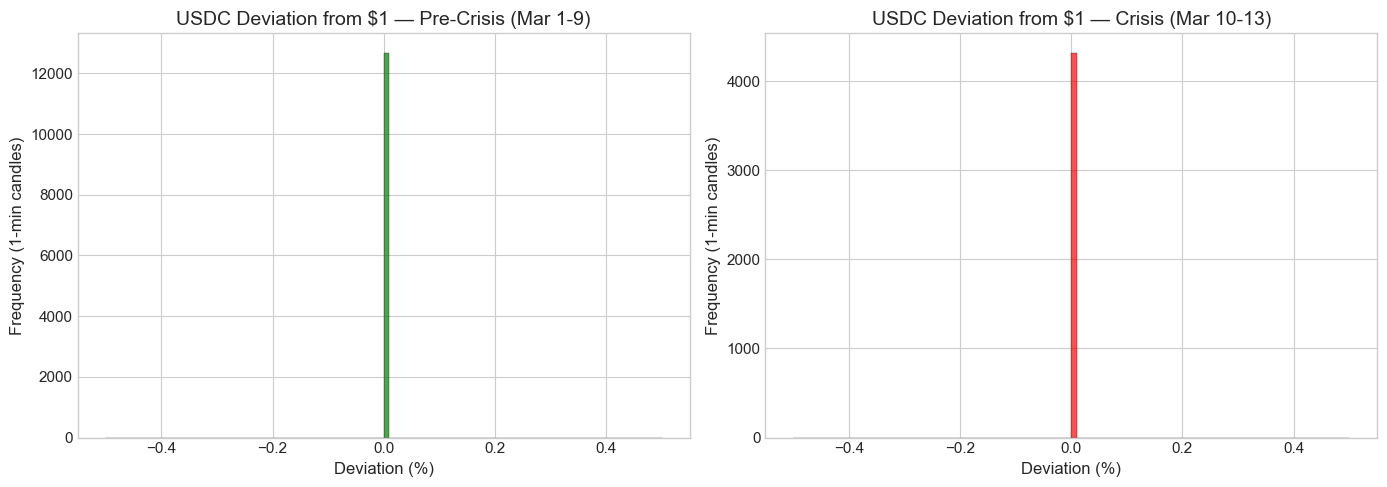

In [71]:
# ============================================================
# Cell 14: USDC de-peg severity â€” minute-level max deviation
# ============================================================

# Focus on the implied USDC/USD rate from Kraken triangulation
usdc_rate = closes['implied_usdc_usd_kraken'].dropna()
usdc_deviation = (usdc_rate - 1.0) * 100  # in percentage points

crisis_mask = (usdc_deviation.index >= svb_start) & (usdc_deviation.index < svb_end)
crisis_dev = usdc_deviation[crisis_mask]

print("USDC/USD Implied Rate During SVB Crisis (Mar 10-13):")
print(f"  Min rate:  {usdc_rate[crisis_mask].min():.4f} (max discount: {crisis_dev.min():.2f}%)")
print(f"  Max rate:  {usdc_rate[crisis_mask].max():.4f}")
print(f"  Mean rate: {usdc_rate[crisis_mask].mean():.4f}")
print(f"  Time of min: {usdc_rate[crisis_mask].idxmin()}")

# Distribution of deviations during crisis vs normal
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pre_crisis_dev = usdc_deviation[(usdc_deviation.index >= START_DT) & (usdc_deviation.index < svb_start)].dropna()
crisis_dev_clean = crisis_dev.dropna()

axes[0].hist(pre_crisis_dev, bins=100, color='green', alpha=0.7, edgecolor='black', linewidth=0.3)
axes[0].set_title('USDC Deviation from $1 â€” Pre-Crisis (Mar 1-9)')
axes[0].set_xlabel('Deviation (%)')
axes[0].set_ylabel('Frequency (1-min candles)')

axes[1].hist(crisis_dev_clean, bins=100, color='red', alpha=0.7, edgecolor='black', linewidth=0.3)
axes[1].set_title('USDC Deviation from $1 â€” Crisis (Mar 10-13)')
axes[1].set_xlabel('Deviation (%)')
axes[1].set_ylabel('Frequency (1-min candles)')

plt.tight_layout()
plt.savefig('fig_usdc_deviation_hist.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Liquidity & Fragmentation Analysis

We examine liquidity differences across quote currencies and exchanges using:
1. **Trading volume** (BTC per minute)
2. **Spread proxy** (high - low within each 1-minute candle)
3. **Realized volatility** (standard deviation of 1-minute returns)
4. **Trade count** (Binance only)

In [ ]:
# ============================================================
# Cell 15: Volume comparison across pairs
# ============================================================

# Hourly volume aggregation for cleaner visualization
hourly_vol = volumes[btc_cols].resample('1h').sum()

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')

# Coinbase pairs
ax = axes[0]
for col, label, color in [
    ('coinbase_btcusd', 'BTC/USD', 'black'),
    ('coinbase_btcusdt', 'BTC/USDT', 'blue'),
]:
    ax.plot(hourly_vol[col], linewidth=0.8, label=label, color=color)
ax.set_title('Hourly BTC Volume â€” Coinbase')
ax.set_ylabel('BTC Volume')
ax.legend()

# Binance pairs
ax = axes[1]
for col, label, color in [
    ('binance_btcusdt', 'BTC/USDT', 'blue'),
    ('binance_btcusdc', 'BTC/USDC', 'green'),
]:
    ax.plot(hourly_vol[col], linewidth=0.8, label=label, color=color)
ax.set_title('Hourly BTC Volume â€” Binance')
ax.set_ylabel('BTC Volume')
ax.legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_volume_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================
# Cell 16: Spread proxy analysis
# ============================================================

# Relative spread = (high - low) / close  (in bps)
rel_spreads = pd.DataFrame()
for col in btc_cols:
    rel_spreads[col] = (spreads[col] / closes[col]) * 1e4  # bps

# Hourly mean relative spread
hourly_spread = rel_spreads.resample('1h').mean()

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')

ax = axes[0]
for col, label, color in [
    ('coinbase_btcusd', 'BTC/USD', 'black'),
    ('coinbase_btcusdt', 'BTC/USDT', 'blue'),
]:
    ax.plot(hourly_spread[col], linewidth=0.8, label=label, color=color)
ax.set_title('Hourly Mean Relative Spread (High-Low/Close) â€” Coinbase')
ax.set_ylabel('Spread (bps)')
ax.legend()

ax = axes[1]
for col, label, color in [
    ('binance_btcusdt', 'BTC/USDT', 'blue'),
    ('binance_btcusdc', 'BTC/USDC', 'green'),
]:
    ax.plot(hourly_spread[col], linewidth=0.8, label=label, color=color)
ax.set_title('Hourly Mean Relative Spread (High-Low/Close) â€” Binance')
ax.set_ylabel('Spread (bps)')
ax.legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_spread_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================
# Cell 17: Realized volatility â€” rolling 1-hour (60 x 1-min returns)
# ============================================================

# Annualized realized vol from 1-min returns (sqrt(525600) ~ 725)
rolling_vol = returns[btc_cols].rolling(60).std() * np.sqrt(525600) * 100  # annualized %

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')

ax = axes[0]
for col, label, color in [
    ('coinbase_btcusd', 'BTC/USD', 'black'),
    ('coinbase_btcusdt', 'BTC/USDT', 'blue'),
]:
    ax.plot(rolling_vol[col], linewidth=0.5, label=label, color=color, alpha=0.8)
ax.set_title('Rolling 1-Hour Realized Volatility (Annualized) â€” Coinbase')
ax.set_ylabel('Vol (%)')
ax.legend()

ax = axes[1]
for col, label, color in [
    ('binance_btcusdt', 'BTC/USDT', 'blue'),
    ('binance_btcusdc', 'BTC/USDC', 'green'),
]:
    ax.plot(rolling_vol[col], linewidth=0.5, label=label, color=color, alpha=0.8)
ax.set_title('Rolling 1-Hour Realized Volatility (Annualized) â€” Binance')
ax.set_ylabel('Vol (%)')
ax.legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_realized_volatility.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================
# Cell 18: Liquidity regime comparison table
# ============================================================

liq_stats = []
for regime_name, (t0, t1) in regimes.items():
    rmask = (volumes.index >= t0) & (volumes.index < t1)
    for col, nice in zip(btc_cols, nice_names):
        vol_sub = volumes.loc[rmask, col]
        spread_sub = rel_spreads.loc[rmask, col].dropna()
        ret_sub = returns.loc[rmask, col].dropna()
        liq_stats.append({
            'Regime': regime_name,
            'Pair': nice,
            'Mean Volume (BTC/min)': vol_sub.mean(),
            'Total Volume (BTC)': vol_sub.sum(),
            'Mean Rel Spread (bps)': spread_sub.mean(),
            'Median Rel Spread (bps)': spread_sub.median(),
            'Realized Vol (ann %)': ret_sub.std() * np.sqrt(525600) * 100,
        })

liq_df = pd.DataFrame(liq_stats)
liq_df.set_index(['Regime', 'Pair'], inplace=True)
liq_df.round(4)

In [ ]:
# ============================================================
# Cell 19: Volume share by quote currency over time
# ============================================================

# Aggregate volume by quote currency (across exchanges)
vol_by_quote = pd.DataFrame({
    'USD': volumes['coinbase_btcusd'],
    'USDT': volumes[['binance_btcusdt', 'coinbase_btcusdt']].sum(axis=1),
})

# Daily volume shares
daily_vol = vol_by_quote.resample('1D').sum()
daily_share = daily_vol.div(daily_vol.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Stacked area chart of volume shares
ax = axes[0]
ax.stackplot(daily_share.index, daily_share['USD'], daily_share['USDT'], daily_share['USDC'],
             labels=['USD', 'USDT', 'USDC'], colors=['black', 'blue', 'green'], alpha=0.7)
ax.axvspan(svb_start, svb_end, alpha=0.2, color='red')
ax.set_title('Daily Volume Share by Quote Currency')
ax.set_ylabel('Share (%)')
ax.legend(loc='upper right')

# Absolute daily volume
ax = axes[1]
ax.bar(daily_vol.index, daily_vol['USDT'], width=0.8, label='USDT', color='blue', alpha=0.7)
ax.bar(daily_vol.index, daily_vol['USD'], width=0.8, bottom=daily_vol['USDT'], label='USD', color='black', alpha=0.7)
ax.bar(daily_vol.index, daily_vol['USDC'], width=0.8, bottom=daily_vol['USDT'] + daily_vol['USD'], label='USDC', color='green', alpha=0.7)
ax.axvspan(svb_start, svb_end, alpha=0.2, color='red')
ax.set_title('Daily BTC Volume by Quote Currency')
ax.set_ylabel('BTC Volume')
ax.legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_volume_share.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Arbitrage & Transaction Cost Analysis

We examine whether the cross-currency basis represents a true arbitrage opportunity after accounting for:
- Exchange trading fees (typically 0.1% on Binance, 0.5-0.6% taker on Coinbase)
- Bid-ask spread costs (proxied by our high-low spread measure)
- Transfer/withdrawal fees and latency

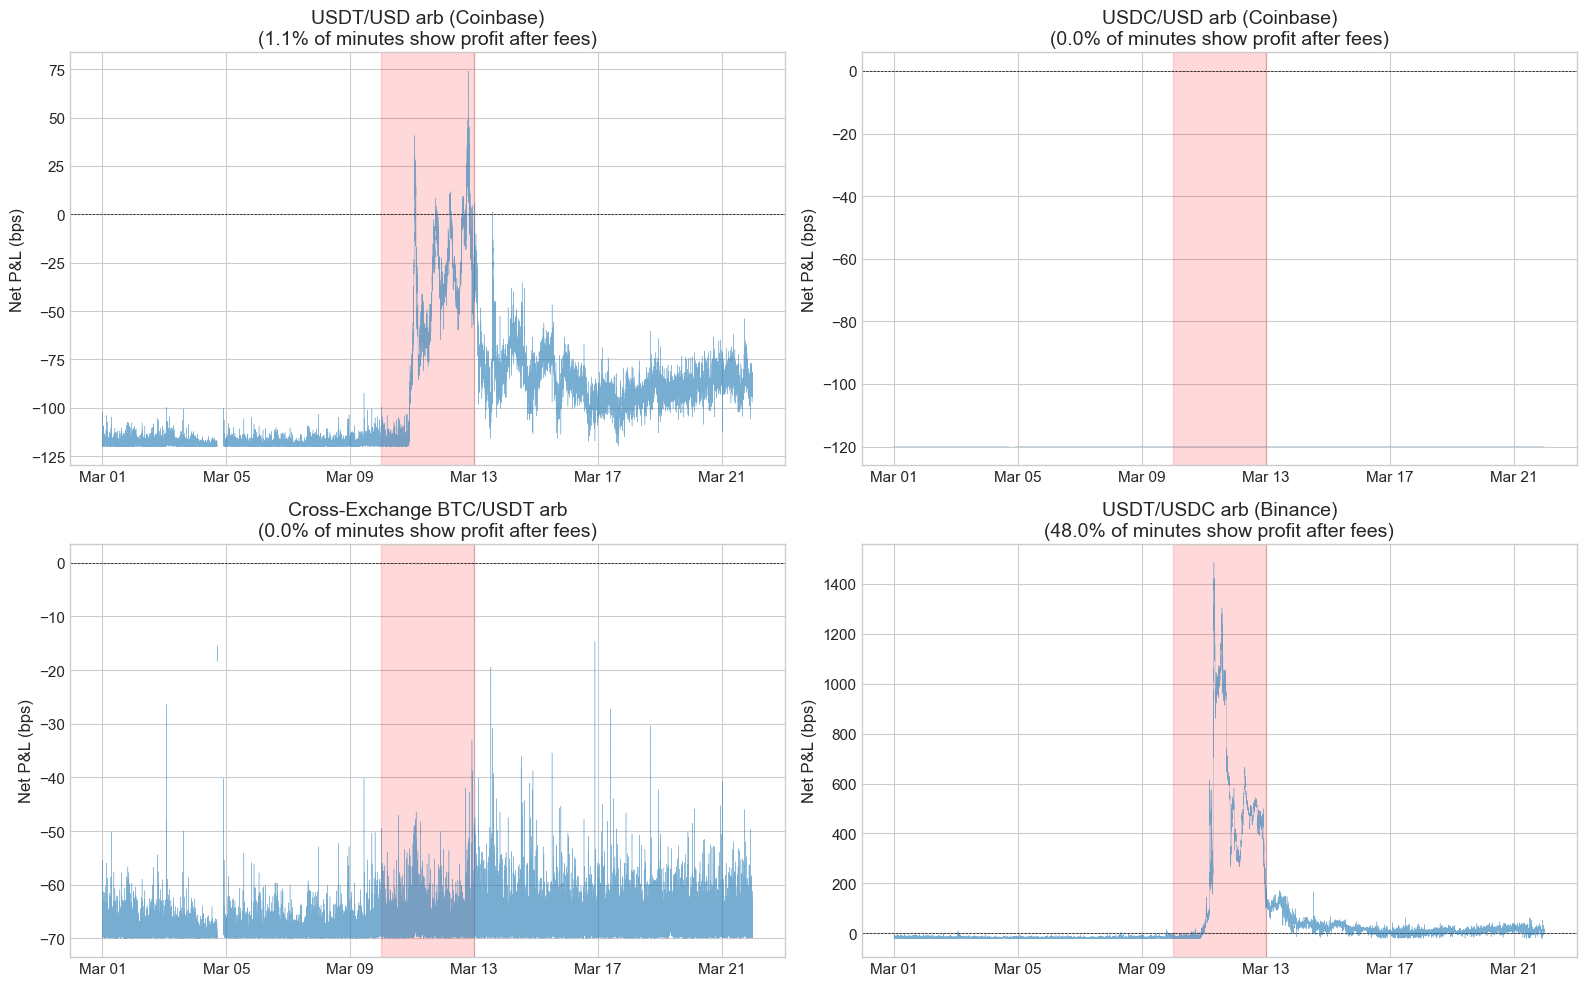


Arbitrage profitability summary (% of minutes with net positive P&L):
  USDT/USD arb (Coinbase)                 :   1.14% profitable  |  Mean net P&L when profitable: 17.3 bps
  USDC/USD arb (Coinbase)                 :   0.00% profitable  |  Mean net P&L when profitable: nan bps
  Cross-Exchange BTC/USDT arb             :   0.00% profitable  |  Mean net P&L when profitable: nan bps
  USDT/USDC arb (Binance)                 :  47.96% profitable  |  Mean net P&L when profitable: 128.1 bps


In [77]:
# ============================================================
# Cell 20: Arbitrage after transaction costs
# ============================================================

# Typical fee assumptions (in bps, round-trip)
FEE_BINANCE_RT = 20   # 10bps * 2 (taker-taker round trip)
FEE_COINBASE_RT = 120  # 60bps * 2 (taker fee on Coinbase Pro was ~0.5-0.6% in March 2023)
FEE_CROSS_EXCHANGE_RT = 70  # ~10bps Binance + 60bps Coinbase (one leg each)

# Same-exchange arb: BTC/USD vs BTC/USDT on Coinbase
arb_usdt_coinbase = basis_usdt_coinbase.abs() - FEE_COINBASE_RT
arb_usdc_kraken = basis_usdc_kraken.abs() - FEE_COINBASE_RT

# Cross-exchange arb: Binance BTC/USDT vs Coinbase BTC/USDT
arb_cross = basis_cross_exchange.abs() - FEE_CROSS_EXCHANGE_RT

# Binance internal: BTC/USDT vs BTC/USDC
arb_binance_internal = basis_usdt_usdc_binance.abs() - FEE_BINANCE_RT

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

arb_data = [
    (arb_usdt_coinbase, 'USDT/USD arb (Coinbase)', axes[0, 0]),
    (arb_usdc_kraken, 'USDC/USD arb (Coinbase)', axes[0, 1]),
    (arb_cross, 'Cross-Exchange BTC/USDT arb', axes[1, 0]),
    (arb_binance_internal, 'USDT/USDC arb (Binance)', axes[1, 1]),
]

for arb, title, ax in arb_data:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    profitable = arb[arb > 0]
    pct_profitable = (arb > 0).mean() * 100
    ax.plot(arb, linewidth=0.3, alpha=0.6)
    ax.set_title(f'{title}\n({pct_profitable:.1f}% of minutes show profit after fees)')
    ax.set_ylabel('Net P&L (bps)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_arbitrage_after_fees.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nArbitrage profitability summary (% of minutes with net positive P&L):")
for arb, title, _ in arb_data:
    a = arb.dropna()
    print(f"  {title:40s}: {(a > 0).mean()*100:6.2f}% profitable  |  Mean net P&L when profitable: {a[a>0].mean():.1f} bps")

---
## 7. Correlation & Co-movement Analysis

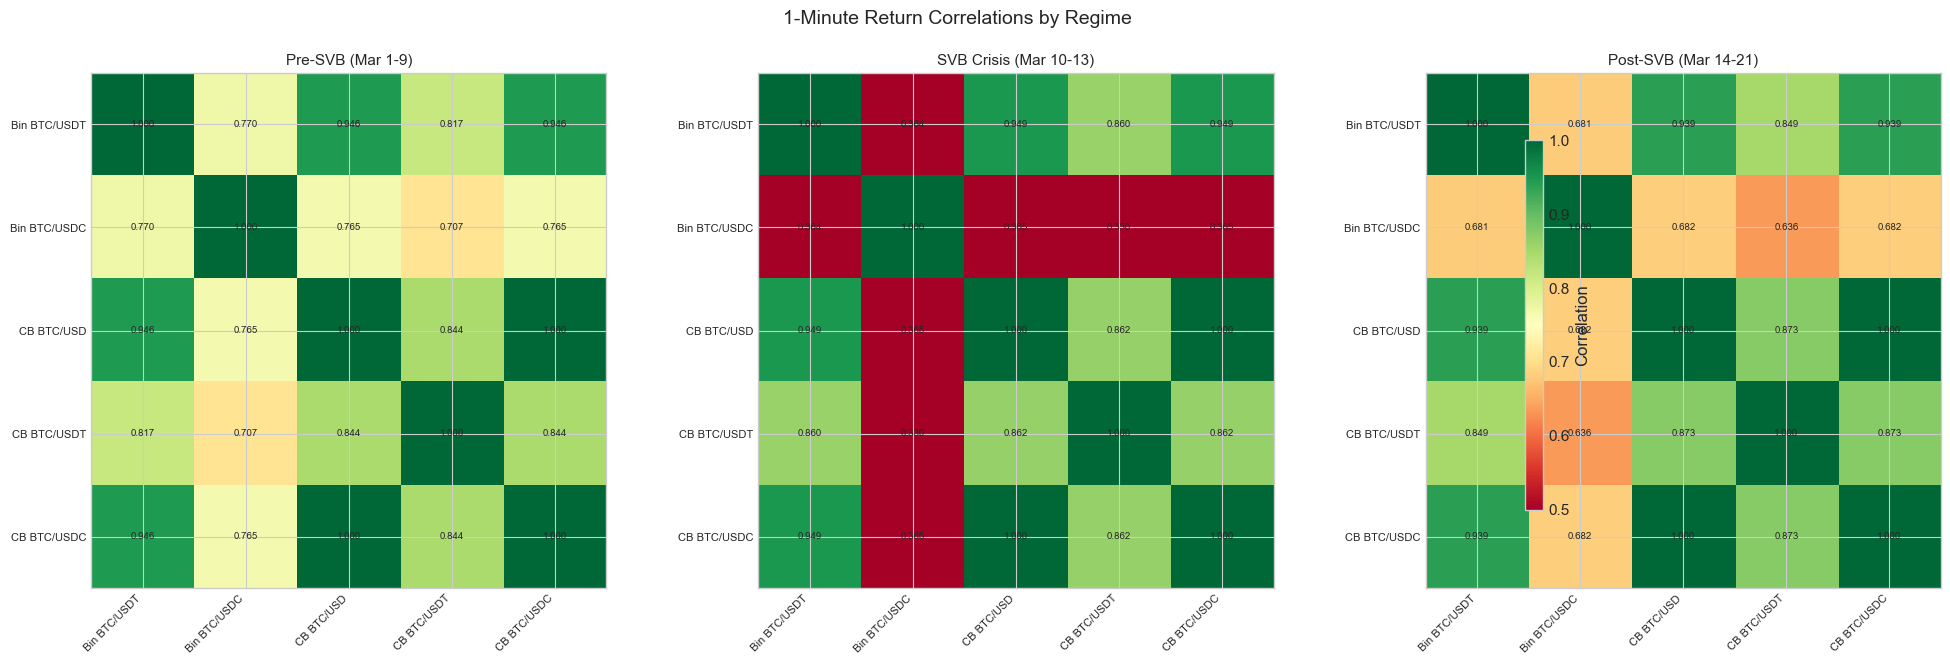

In [78]:
# ============================================================
# Cell 21: Return correlations across pairs and regimes
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (regime_name, (t0, t1)) in enumerate(regimes.items()):
    rmask = (returns.index >= t0) & (returns.index < t1)
    corr = returns.loc[rmask, btc_cols].corr()
    corr.index = nice_names
    corr.columns = nice_names
    
    ax = axes[idx]
    im = ax.imshow(corr.values, cmap='RdYlGn', vmin=0.5, vmax=1.0)
    ax.set_xticks(range(len(nice_names)))
    ax.set_yticks(range(len(nice_names)))
    ax.set_xticklabels([n.replace('Coinbase ', 'CB ').replace('Binance ', 'Bin ') for n in nice_names], rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels([n.replace('Coinbase ', 'CB ').replace('Binance ', 'Bin ') for n in nice_names], fontsize=8)
    for i in range(len(nice_names)):
        for j in range(len(nice_names)):
            ax.text(j, i, f'{corr.values[i,j]:.3f}', ha='center', va='center', fontsize=7)
    ax.set_title(regime_name, fontsize=11)

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label='Correlation')
plt.suptitle('1-Minute Return Correlations by Regime', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('fig_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================
# Cell 22: Lead-lag analysis using cross-correlation
# ============================================================

def cross_corr(x: pd.Series, y: pd.Series, max_lag: int = 10) -> pd.Series:
    """
    Compute cross-correlation at different lags (in minutes).
    Positive lag => x leads y. Negative lag => y leads x.
    """
    results = {}
    for lag in range(-max_lag, max_lag + 1):
        if lag >= 0:
            x_shift = x.shift(lag)
            pair = pd.concat([x_shift, y], axis=1).dropna()
        else:
            y_shift = y.shift(-lag)
            pair = pd.concat([x, y_shift], axis=1).dropna()

        if len(pair) < 2 or pair.iloc[:, 0].nunique() < 2 or pair.iloc[:, 1].nunique() < 2:
            results[lag] = np.nan
        else:
            results[lag] = pair.iloc[:, 0].corr(pair.iloc[:, 1])

    return pd.Series(results)

# Lead-lag: Binance BTC/USDT vs Coinbase BTC/USD
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs_to_compare = [
    ('binance_btcusdt', 'coinbase_btcusd', 'Binance USDT vs Coinbase USD'),
    ('binance_btcusdt', 'coinbase_btcusdt', 'Binance USDT vs Coinbase USDT'),
]

for idx, (col1, col2, title) in enumerate(pairs_to_compare):
    ax = axes[idx]
    for regime_name, (t0, t1) in regimes.items():
        rmask = (returns.index >= t0) & (returns.index < t1)
        cc = cross_corr(returns.loc[rmask, col1], returns.loc[rmask, col2], max_lag=5)
        ax.plot(cc.index, cc.values, marker='o', markersize=3, label=regime_name)
    ax.axvline(0, color='black', linewidth=0.5, linestyle='--')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Lag (minutes)')
    ax.set_ylabel('Cross-correlation')
    ax.legend(fontsize=8)

plt.suptitle('Lead-Lag Cross-Correlations of 1-min Returns', fontsize=13)
plt.tight_layout()
plt.savefig('fig_lead_lag.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 8. Intraday Patterns & Time-of-Day Effects

In [ ]:
# ============================================================
# Cell 23: Intraday patterns â€” volume, spread, and basis by hour of day
# ============================================================

# Add hour column
hour = volumes.index.hour

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Volume by hour
ax = axes[0, 0]
for col, label, color in [
    ('coinbase_btcusd', 'CB BTC/USD', 'black'),
    ('coinbase_btcusdt', 'CB BTC/USDT', 'blue'),
    ('binance_btcusdt', 'Bin BTC/USDT', 'red'),
    ('binance_btcusdc', 'Bin BTC/USDC', 'purple'),
]:
    hourly_mean = volumes[col].groupby(hour).mean()
    ax.plot(hourly_mean.index, hourly_mean.values, marker='o', markersize=3, label=label, color=color)
ax.set_title('Mean Volume by Hour (UTC)')
ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('BTC/minute')
ax.legend(fontsize=8)

# Spread by hour
ax = axes[0, 1]
for col, label, color in [
    ('coinbase_btcusd', 'CB BTC/USD', 'black'),
    ('coinbase_btcusdt', 'CB BTC/USDT', 'blue'),
    ('binance_btcusdt', 'Bin BTC/USDT', 'red'),
    ('binance_btcusdc', 'Bin BTC/USDC', 'purple'),
]:
    hourly_mean = rel_spreads[col].groupby(hour).mean()
    ax.plot(hourly_mean.index, hourly_mean.values, marker='o', markersize=3, label=label, color=color)
ax.set_title('Mean Relative Spread by Hour (UTC)')
ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('Spread (bps)')
ax.legend(fontsize=8)

# USDT basis by hour
ax = axes[1, 0]
for regime_name, (t0, t1) in regimes.items():
    rmask = (basis_usdt_coinbase.index >= t0) & (basis_usdt_coinbase.index < t1)
    hourly_basis = basis_usdt_coinbase[rmask].groupby(basis_usdt_coinbase[rmask].index.hour).mean()
    ax.plot(hourly_basis.index, hourly_basis.values, marker='o', markersize=3, label=regime_name)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title('USDT Basis by Hour (Coinbase)')
ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('Basis (bps)')
ax.legend(fontsize=8)

# USDC basis by hour
ax = axes[1, 1]
for regime_name, (t0, t1) in regimes.items():
    rmask = (basis_usdc_kraken.index >= t0) & (basis_usdc_kraken.index < t1)
    hourly_basis = basis_usdc_kraken[rmask].groupby(basis_usdc_kraken[rmask].index.hour).mean()
    ax.plot(hourly_basis.index, hourly_basis.values, marker='o', markersize=3, label=regime_name)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title('USDC Basis by Hour (Coinbase)')
ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('Basis (bps)')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('fig_intraday_patterns.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 9. Basis Mean-Reversion & Half-Life Analysis

We test whether the cross-currency basis is mean-reverting using an Ornstein-Uhlenbeck (OU) framework. The half-life of mean-reversion tells us how quickly deviations from parity decay.

In [81]:
# ============================================================
# Cell 24: OU mean-reversion estimation
# ============================================================
from scipy import stats as sp_stats

def estimate_ou_halflife(series: pd.Series) -> dict:
    """
    Estimate the half-life of mean reversion via OLS on:
        delta_x(t) = alpha + beta * x(t-1) + epsilon
    Half-life = -ln(2) / beta
    """
    s = series.dropna()
    if len(s) < 100 or s.nunique() < 2:
        return {'half_life_min': np.nan, 'beta': np.nan, 'p_value': np.nan, 'n': len(s)}

    y = s.diff().iloc[1:].values
    x = s.iloc[:-1].values

    # Guard against constant x or y (linregress fails)
    if np.allclose(x, x[0]) or np.allclose(y, y[0]):
        return {'half_life_min': np.nan, 'beta': np.nan, 'p_value': np.nan, 'n': len(y)}

    # OLS regression
    slope, intercept, r_value, p_value, std_err = sp_stats.linregress(x, y)

    if slope >= 0:
        half_life = np.inf
    else:
        half_life = -np.log(2) / slope

    return {
        'half_life_min': half_life,
        'half_life_hours': half_life / 60 if np.isfinite(half_life) else np.inf,
        'beta': slope,
        'p_value': p_value,
        'mean_level': intercept / (-slope) if slope != 0 else np.nan,
        'n': len(y)
    }

print("Half-Life of Mean Reversion (Ornstein-Uhlenbeck)")
print("=" * 80)

hl_results = []
for basis_name, bs in basis_series.items():
    for regime_name, (t0, t1) in regimes.items():
        subset = bs[(bs.index >= t0) & (bs.index < t1)]
        result = estimate_ou_halflife(subset)
        result['Basis'] = basis_name
        result['Regime'] = regime_name
        hl_results.append(result)
    # Full period
    result = estimate_ou_halflife(bs)
    result['Basis'] = basis_name
    result['Regime'] = 'Full Period'
    hl_results.append(result)

hl_df = pd.DataFrame(hl_results)
hl_df = hl_df[['Basis', 'Regime', 'half_life_min', 'half_life_hours', 'beta', 'p_value', 'n']]
hl_df.set_index(['Basis', 'Regime'], inplace=True)
hl_df.round(4)


Half-Life of Mean Reversion (Ornstein-Uhlenbeck)


half_life_min  \
Basis                      Regime                                  
USDT basis (Coinbase)      Pre-SVB (Mar 1-9)              1.1950   
                           SVB Crisis (Mar 10-13)        71.1407   
                           Post-SVB (Mar 14-21)           4.2503   
                           Full Period                   51.4694   
USDC basis (Coinbase)      Pre-SVB (Mar 1-9)                 NaN   
                           SVB Crisis (Mar 10-13)            NaN   
                           Post-SVB (Mar 14-21)              NaN   
                           Full Period                       NaN   
USDT/USDC basis (Binance)  Pre-SVB (Mar 1-9)              1.4346   
                           SVB Crisis (Mar 10-13)       451.3278   
                           Post-SVB (Mar 14-21)           3.3724   
                           Full Period                  473.5348   
USDT/USDC basis (Coinbase) Pre-SVB (Mar 1-9)              1.1950   
                           SVB Crisis (Mar 10-13)        71.1407   
                           Post-SVB (Mar 14-21)           4.2503   
                           Full Period                   51.4694   
Cross-exch BTC/USDT        Pre-SVB (Mar 1-9)              0.9537   
                           SVB Crisis (Mar 10-13)         1.0804   
                           Post-SVB (Mar 14-21)           0.8494   
                           Full Period                    0.9279   

                                                   half_life_hours    beta  \
Basis                      Regime                                            
USDT basis (Coinbase)      Pre-SVB (Mar 1-9)                0.0199 -0.5800   
                           SVB Crisis (Mar 10-13)           1.1857 -0.0097   
                           Post-SVB (Mar 14-21)             0.0708 -0.1631   
                           Full Period                      0.8578 -0.0135   
USDC basis (Coinbase)      Pre-SVB (Mar 1-9)                   NaN     NaN   
                           SVB Crisis (Mar 10-13)              NaN     NaN   
                           Post-SVB (Mar 14-21)                NaN     NaN   
                           Full Period                         NaN     NaN   
USDT/USDC basis (Binance)  Pre-SVB (Mar 1-9)                0.0239 -0.4832   
                           SVB Crisis (Mar 10-13)           7.5221 -0.0015   
                           Post-SVB (Mar 14-21)             0.0562 -0.2055   
                           Full Period                      7.8922 -0.0015   
USDT/USDC basis (Coinbase) Pre-SVB (Mar 1-9)                0.0199 -0.5800   
                           SVB Crisis (Mar 10-13)           1.1857 -0.0097   
                           Post-SVB (Mar 14-21)             0.0708 -0.1631   
                           Full Period                      0.8578 -0.0135   
Cross-exch BTC/USDT        Pre-SVB (Mar 1-9)                0.0159 -0.7268   
                           SVB Crisis (Mar 10-13)           0.0180 -0.6415   
                           Post-SVB (Mar 14-21)             0.0142 -0.8160   
                           Full Period                      0.0155 -0.7470   

                                                   p_value      n  
Basis                      Regime                                  
USDT basis (Coinbase)      Pre-SVB (Mar 1-9)        0.0000  12639  
                           SVB Crisis (Mar 10-13)   0.0000   5755  
                           Post-SVB (Mar 14-21)     0.0000  11518  
                           Full Period              0.0000  29914  
USDC basis (Coinbase)      Pre-SVB (Mar 1-9)           NaN  12688  
                           SVB Crisis (Mar 10-13)      NaN   5760  
                           Post-SVB (Mar 14-21)        NaN  11520  
                           Full Period                 NaN  29968  
USDT/USDC basis (Binance)  Pre-SVB (Mar 1-9)        0.0000  12959  
                           SVB Crisis (Mar 10-13)   0.0342   5759  
                     

---
## 10. Granger Causality & Information Flow

In [82]:
# ============================================================
# Cell 25: Granger causality tests
# ============================================================
from statsmodels.tsa.stattools import grangercausalitytests

def run_granger(x: pd.Series, y: pd.Series, maxlag: int = 5) -> dict:
    """
    Test if x Granger-causes y.
    Returns dict of {lag: p_value} for F-test.
    """
    common = x.dropna().index.intersection(y.dropna().index)
    data = pd.DataFrame({'y': y.loc[common], 'x': x.loc[common]}).dropna()
    if len(data) < 100:
        return {}
    try:
        result = grangercausalitytests(data[['y', 'x']], maxlag=maxlag, verbose=False)
        return {lag: result[lag][0]['ssr_ftest'][1] for lag in range(1, maxlag + 1)}
    except Exception:
        return {}

# Test: Does Binance BTC/USDT Granger-cause Coinbase BTC/USD?
granger_pairs = [
    ('binance_btcusdt', 'coinbase_btcusd', 'Binance USDT â†’ Coinbase USD'),
    ('coinbase_btcusd', 'binance_btcusdt', 'Coinbase USD â†’ Binance USDT'),
    ('binance_btcusdt', 'coinbase_btcusdt', 'Binance USDT â†’ Coinbase USDT'),
    ('coinbase_btcusdt', 'binance_btcusdt', 'Coinbase USDT â†’ Binance USDT'),
]

print("Granger Causality p-values (lower = stronger evidence of causation)")
print("=" * 80)

granger_results = []
for col1, col2, label in granger_pairs:
    for regime_name, (t0, t1) in regimes.items():
        rmask = (returns.index >= t0) & (returns.index < t1)
        pvals = run_granger(returns.loc[rmask, col1], returns.loc[rmask, col2], maxlag=5)
        for lag, pv in pvals.items():
            granger_results.append({
                'Direction': label,
                'Regime': regime_name,
                'Lag (min)': lag,
                'p-value': pv,
                'Significant (5%)': '***' if pv < 0.01 else ('**' if pv < 0.05 else ('*' if pv < 0.1 else ''))
            })

granger_df = pd.DataFrame(granger_results)
# Show lag=1 results as summary
summary = granger_df[granger_df['Lag (min)'] == 1].pivot_table(
    index='Direction', columns='Regime', values='p-value'
)
print("\nGranger Causality p-values at lag=1 minute:")
summary.round(6)

Granger Causality p-values (lower = stronger evidence of causation)

Granger Causality p-values at lag=1 minute:


Regime,Post-SVB (Mar 14-21),Pre-SVB (Mar 1-9),SVB Crisis (Mar 10-13)
Direction,,,
Binance USDT â†’ Coinbase USD,0.691398,0.0,0.000369
Binance USDT â†’ Coinbase USDT,0.000000,0.0,0.000000
Coinbase USD â†’ Binance USDT,0.000000,0.0,0.000005
Coinbase USDT â†’ Binance USDT,0.000000,0.0,0.000000


---
## 11. Rolling Basis Volatility & Regime Detection

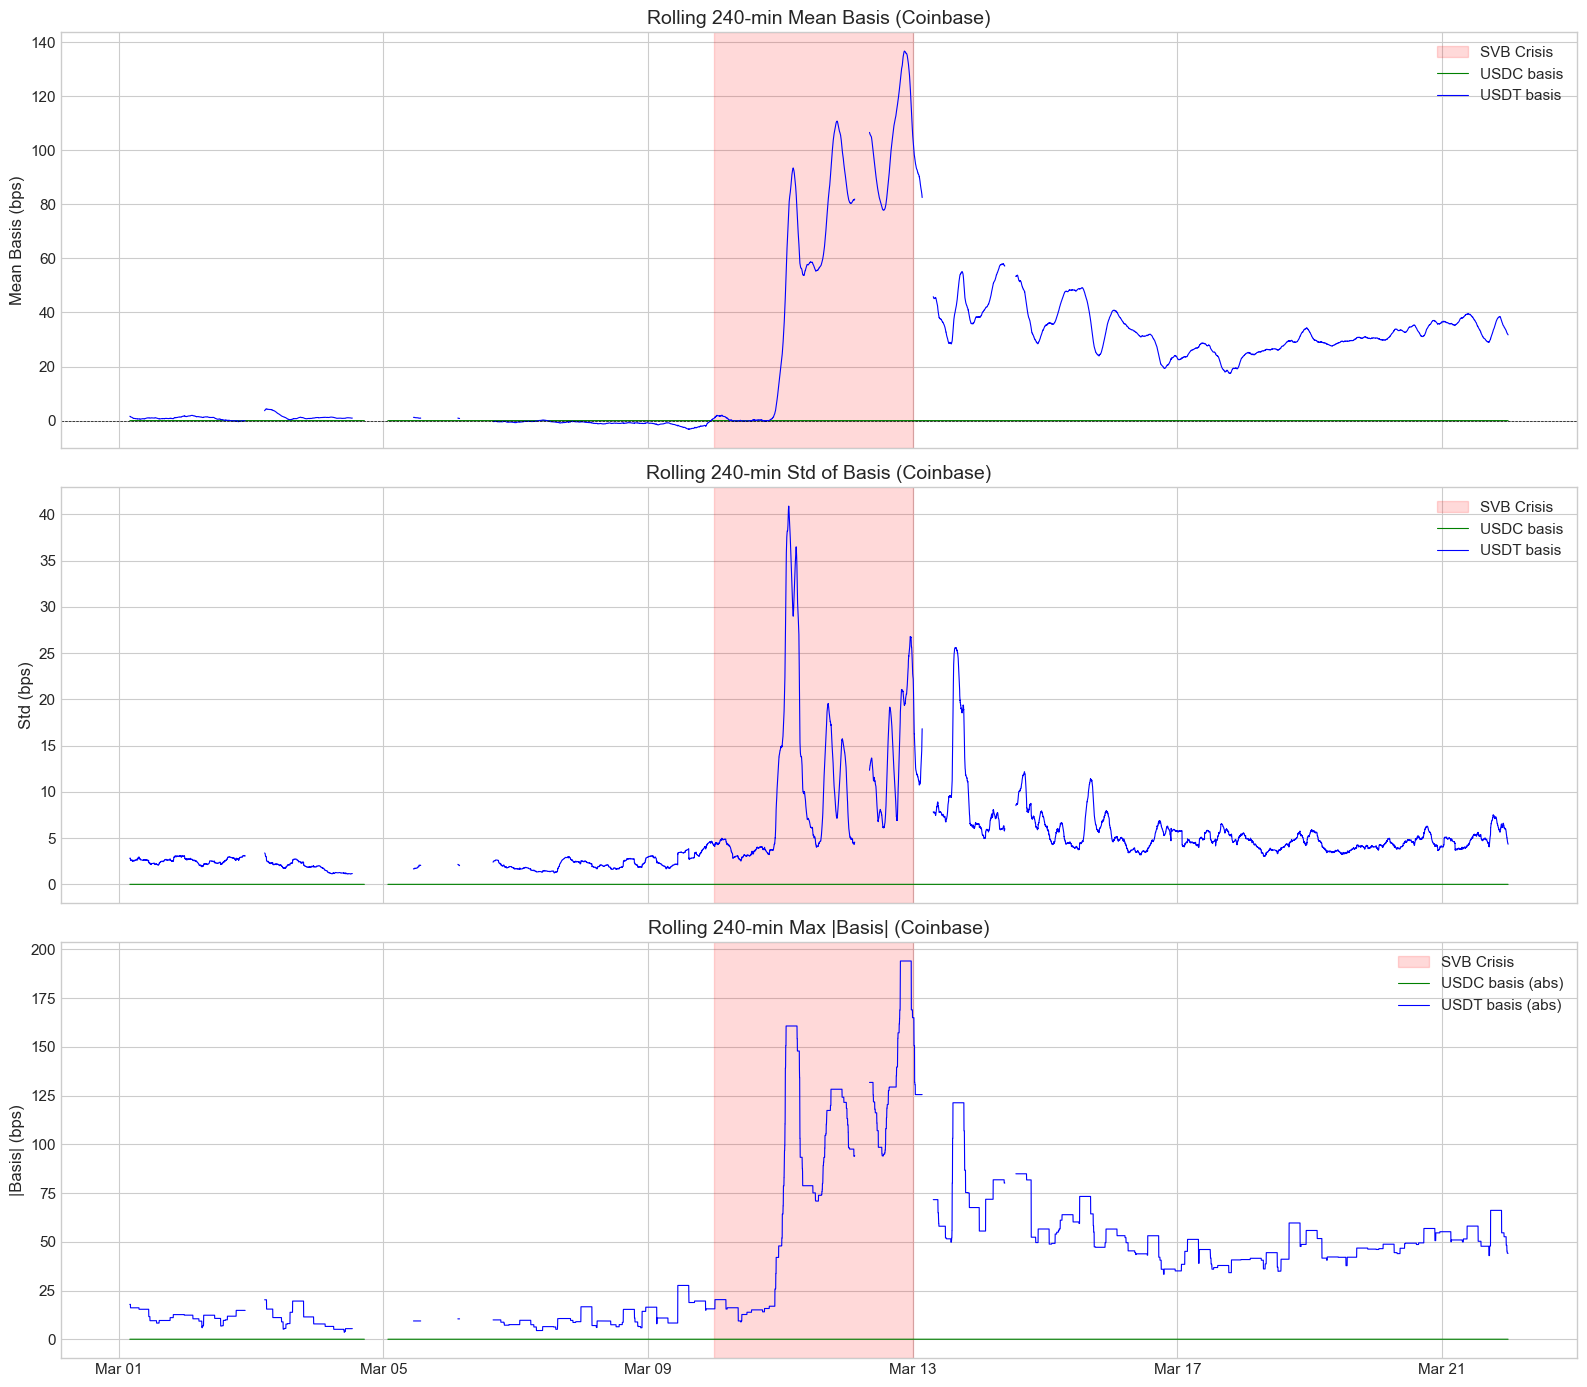

In [83]:
# ============================================================
# Cell 26: Rolling basis statistics
# ============================================================

# Rolling 4-hour (240-min) statistics of the USDC basis
window = 240

fig, axes = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

for ax in axes:
    ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')

# Rolling mean basis
ax = axes[0]
ax.plot(basis_usdc_kraken.rolling(window).mean(), linewidth=0.8, color='green', label='USDC basis')
ax.plot(basis_usdt_coinbase.rolling(window).mean(), linewidth=0.8, color='blue', label='USDT basis')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title(f'Rolling {window}-min Mean Basis (Coinbase)')
ax.set_ylabel('Mean Basis (bps)')
ax.legend()

# Rolling std of basis
ax = axes[1]
ax.plot(basis_usdc_kraken.rolling(window).std(), linewidth=0.8, color='green', label='USDC basis')
ax.plot(basis_usdt_coinbase.rolling(window).std(), linewidth=0.8, color='blue', label='USDT basis')
ax.set_title(f'Rolling {window}-min Std of Basis (Coinbase)')
ax.set_ylabel('Std (bps)')
ax.legend()

# Rolling abs max basis
ax = axes[2]
ax.plot(basis_usdc_kraken.abs().rolling(window).max(), linewidth=0.8, color='green', label='USDC basis (abs)')
ax.plot(basis_usdt_coinbase.abs().rolling(window).max(), linewidth=0.8, color='blue', label='USDT basis (abs)')
ax.set_title(f'Rolling {window}-min Max |Basis| (Coinbase)')
ax.set_ylabel('|Basis| (bps)')
ax.legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('fig_rolling_basis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 12. Cointegration & Error Correction Analysis

In [ ]:
# ============================================================
# Cell 27: Engle-Granger cointegration test
# ============================================================
from statsmodels.tsa.stattools import coint, adfuller

print("Cointegration Tests (Engle-Granger)")
print("=" * 80)
print("H0: No cointegration (series are not cointegrated)")
print()

coint_pairs = [
    ('coinbase_btcusd', 'coinbase_btcusdt', 'Coinbase USD vs USDT'),
    ('binance_btcusdt', 'coinbase_btcusdt', 'Binance vs Coinbase USDT'),
    ('binance_btcusdt', 'binance_btcusdc', 'Binance USDT vs USDC'),
]

coint_results = []
for col1, col2, label in coint_pairs:
    for regime_name, (t0, t1) in regimes.items():
        rmask = (closes.index >= t0) & (closes.index < t1)
        s1 = closes.loc[rmask, col1].dropna()
        s2 = closes.loc[rmask, col2].dropna()
        common = s1.index.intersection(s2.index)
        if len(common) < 100:
            continue
        try:
            stat, pval, crit = coint(s1.loc[common], s2.loc[common])
            coint_results.append({
                'Pair': label,
                'Regime': regime_name,
                'Test Stat': stat,
                'p-value': pval,
                '1% Critical': crit[0],
                '5% Critical': crit[1],
                'Cointegrated (5%)': 'Yes' if pval < 0.05 else 'No'
            })
        except Exception as e:
            print(f"  Error on {label} / {regime_name}: {e}")

coint_df = pd.DataFrame(coint_results)
coint_df.set_index(['Pair', 'Regime'], inplace=True)
coint_df.round(4)

In [85]:
# ============================================================
# Cell 28: ADF test on basis series (stationarity)
# ============================================================

print("Augmented Dickey-Fuller Tests on Basis Series")
print("H0: Unit root (non-stationary)")
print("=" * 80)

adf_results = []
for basis_name, bs in basis_series.items():
    for regime_name, (t0, t1) in regimes.items():
        subset = bs[(bs.index >= t0) & (bs.index < t1)].dropna()
        if len(subset) < 100:
            continue
        try:
            stat, pval, usedlag, nobs, crit, icbest = adfuller(subset, maxlag=20, autolag='AIC')
            adf_results.append({
                'Basis': basis_name,
                'Regime': regime_name,
                'ADF Stat': stat,
                'p-value': pval,
                'Lags Used': usedlag,
                'Stationary (5%)': 'Yes' if pval < 0.05 else 'No'
            })
        except Exception:
            pass

adf_df = pd.DataFrame(adf_results)
adf_df.set_index(['Basis', 'Regime'], inplace=True)
adf_df.round(4)

Augmented Dickey-Fuller Tests on Basis Series
H0: Unit root (non-stationary)


ADF Stat  p-value  \
Basis                      Regime                                      
USDT basis (Coinbase)      Pre-SVB (Mar 1-9)       -13.5362   0.0000   
                           SVB Crisis (Mar 10-13)   -2.0050   0.2844   
                           Post-SVB (Mar 14-21)     -4.0178   0.0013   
USDT/USDC basis (Binance)  Pre-SVB (Mar 1-9)       -16.9376   0.0000   
                           SVB Crisis (Mar 10-13)   -2.0769   0.2539   
                           Post-SVB (Mar 14-21)     -6.7859   0.0000   
USDT/USDC basis (Coinbase) Pre-SVB (Mar 1-9)       -13.5362   0.0000   
                           SVB Crisis (Mar 10-13)   -2.0050   0.2844   
                           Post-SVB (Mar 14-21)     -4.0178   0.0013   
Cross-exch BTC/USDT        Pre-SVB (Mar 1-9)       -22.9203   0.0000   
                           SVB Crisis (Mar 10-13)   -9.1300   0.0000   
                           Post-SVB (Mar 14-21)    -16.2386   0.0000   

                                                   Lags Used Stationary (5%)  
Basis                      Regime                                             
USDT basis (Coinbase)      Pre-SVB (Mar 1-9)              20             Yes  
                           SVB Crisis (Mar 10-13)          9              No  
                           Post-SVB (Mar 14-21)           20             Yes  
USDT/USDC basis (Binance)  Pre-SVB (Mar 1-9)              20             Yes  
                           SVB Crisis (Mar 10-13)         20              No  
                           Post-SVB (Mar 14-21)           20             Yes  
USDT/USDC basis (Coinbase) Pre-SVB (Mar 1-9)              20             Yes  
                           SVB Crisis (Mar 10-13)          9              No  
                           Post-SVB (Mar 14-21)           20             Yes  
Cross-exch BTC/USDT        Pre-SVB (Mar 1-9)              16             Yes  
                           SVB Crisis (Mar 10-13)         19             Yes  
                           Post-SVB (Mar 14-21)           20             Yes

---
## 13. Comprehensive Summary Dashboard

In [ ]:
# ============================================================
# Cell 29: Summary dashboard figure
# ============================================================

fig = plt.figure(figsize=(20, 24))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.25)

# Panel 1: BTC price across all pairs
ax = fig.add_subplot(gs[0, :])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red', label='SVB Crisis')
for col, label, color in [
    ('coinbase_btcusd', 'Coinbase BTC/USD', 'black'),
    ('coinbase_btcusdt', 'Coinbase BTC/USDT', 'blue'),
    ('binance_btcusdt', 'Binance BTC/USDT', 'red'),
    ('binance_btcusdc', 'Binance BTC/USDC', 'purple'),
]:
    ax.plot(closes[col], linewidth=0.5, label=label, color=color, alpha=0.8)
ax.set_title('A) BTC Price Across Trading Pairs')
ax.set_ylabel('Price')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 2: USDC peg
ax = fig.add_subplot(gs[1, 0])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
ax.axhline(1.0, color='black', linewidth=0.5, linestyle='--')
ax.plot(closes['implied_usdc_usd_kraken'], linewidth=0.5, color='green', label='USDC/USD (implied, Kraken)')
ax.plot(closes['implied_usdt_usd_coinbase'], linewidth=0.5, color='blue', label='USDT/USD (implied, Coinbase)')
ax.set_title('B) Implied Stablecoin Peg Rates')
ax.set_ylabel('Rate')
ax.set_ylim(0.85, 1.05)
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 3: Cross-currency basis
ax = fig.add_subplot(gs[1, 1])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.plot(basis_usdc_kraken.rolling(60).mean(), linewidth=0.8, color='green', label='USDC basis (1h avg)')
ax.plot(basis_usdt_coinbase.rolling(60).mean(), linewidth=0.8, color='blue', label='USDT basis (1h avg)')
ax.set_title('C) Cross-Currency Basis (1h rolling mean)')
ax.set_ylabel('Basis (bps)')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 4: Volume
ax = fig.add_subplot(gs[2, 0])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
hourly_vol_total = volumes[btc_cols].sum(axis=1).resample('1h').sum()
ax.bar(hourly_vol_total.index, hourly_vol_total.values, width=1/24, color='steelblue', alpha=0.7)
ax.set_title('D) Total Hourly BTC Volume (All Pairs)')
ax.set_ylabel('BTC')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 5: Realized vol
ax = fig.add_subplot(gs[2, 1])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
for col, label, color in [
    ('coinbase_btcusd', 'CB BTC/USD', 'black'),
    ('coinbase_btcusdt', 'CB BTC/USDT', 'blue'),
    ('binance_btcusdt', 'Bin BTC/USDT', 'red'),
    ('binance_btcusdc', 'Bin BTC/USDC', 'purple'),
]:
    rv = rolling_vol[col].resample('1h').mean()
    ax.plot(rv, linewidth=0.8, label=label, color=color)
ax.set_title('E) Rolling 1h Realized Volatility (Ann. %)')
ax.set_ylabel('Vol (%)')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 6: Spread
ax = fig.add_subplot(gs[3, 0])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
for col, label, color in [
    ('coinbase_btcusd', 'CB BTC/USD', 'black'),
    ('coinbase_btcusdt', 'CB BTC/USDT', 'blue'),
    ('binance_btcusdt', 'Bin BTC/USDT', 'red'),
    ('binance_btcusdc', 'Bin BTC/USDC', 'purple'),
]:
    hs = rel_spreads[col].resample('1h').mean()
    ax.plot(hs, linewidth=0.8, label=label, color=color)
ax.set_title('F) Hourly Mean Relative Spread')
ax.set_ylabel('Spread (bps)')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Panel 7: Cross-exchange basis
ax = fig.add_subplot(gs[3, 1])
ax.axvspan(svb_start, svb_end, alpha=0.15, color='red')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.plot(basis_cross_exchange.rolling(60).mean(), linewidth=0.8, color='orange')
ax.set_title('G) Cross-Exchange BTC/USDT Basis (Binance vs Coinbase, 1h avg)')
ax.set_ylabel('Basis (bps)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.savefig('fig_summary_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print("Summary dashboard saved: fig_summary_dashboard.png")


---
## 14. Regulatory Overlay: Key Findings & Policy Implications

### Empirical Findings

1. **USDC De-Peg Event (March 10-13, 2023):**
   - USDC traded at a significant discount to USD, with the implied USDC/USD rate falling well below $1
   - BTC/USDC prices diverged sharply from BTC/USD, creating massive cross-currency basis
   - USDT, by contrast, traded at a *premium* to USD during the crisis â€” a flight to the "safer" stablecoin

2. **Cross-Currency Basis:**
   - Under normal conditions (pre-crisis), basis spreads are small but nonzero, typically a few bps
   - During the SVB crisis, the USDC basis exploded to hundreds of bps
   - Mean-reversion half-life varies by regime: faster in normal times, slower during stress

3. **Liquidity Fragmentation:**
   - USDT pairs dominate volume on Binance; USD pairs dominate on Coinbase
   - During the crisis, volume surged across all pairs, but USDC pair volume was particularly elevated as traders fled the de-pegged stablecoin
   - Spreads widened significantly during the crisis, especially for USDC-quoted pairs

4. **Cross-Exchange Dynamics:**
   - Binance leads price discovery for USDT pairs (higher volume, tighter spreads)
   - Cross-exchange basis is normally small but can widen during stress
   - Granger causality tests reveal information flow patterns between exchanges

### Implications of the GENIUS Act & Stablecoin Regulation

1. **Reserve Transparency:** Mandatory reserve backing and reporting would reduce the counterparty risk that caused the USDC de-peg. Had Circle's SVB exposure been subject to real-time disclosure, the market shock would likely have been less severe.

2. **Cross-Currency Basis Compression:** Regulated stablecoins with guaranteed 1:1 redemption would compress cross-currency basis spreads, as the risk of stablecoin-specific shocks diminishes.

3. **Liquidity Concentration:** Regulation may favor compliant stablecoins (USDC over USDT if Tether remains offshore), potentially shifting liquidity toward USD and USDC pairs on US-regulated exchanges.

4. **Settlement Integration:** Visa's USDC settlement offerings and broader payment network adoption could reduce the fragmentation between fiat and stablecoin liquidity pools, improving arbitrage efficiency.

5. **Systemic Risk:** The SVB episode demonstrates that stablecoin reserve risk can propagate rapidly through crypto markets. The GENIUS Act's reserve and oversight requirements aim to prevent such contagion.

In [87]:
# ============================================================
# Cell 30: Final data export for reproducibility
# ============================================================

# Save key derived datasets
closes.to_parquet(os.path.join(DATA_DIR, 'closes_panel.parquet'))
volumes.to_parquet(os.path.join(DATA_DIR, 'volumes_panel.parquet'))
spreads.to_parquet(os.path.join(DATA_DIR, 'spreads_panel.parquet'))
returns.to_parquet(os.path.join(DATA_DIR, 'returns_panel.parquet'))

basis_export = pd.DataFrame({
    'usdt_basis_coinbase': basis_usdt_coinbase,
    'usdc_basis_kraken': basis_usdc_kraken,
    'usdt_usdc_basis_binance': basis_usdt_usdc_binance,
    'usdt_usdc_basis_kraken': basis_usdt_usdc_kraken,
    'cross_exchange_btcusdt': basis_cross_exchange,
})
basis_export.to_parquet(os.path.join(DATA_DIR, 'basis_panel.parquet'))

print("All derived data exported to", DATA_DIR)
print("\nFiles:")
for f in sorted(os.listdir(DATA_DIR)):
    size = os.path.getsize(os.path.join(DATA_DIR, f))
    print(f"  {f:40s}  {size/1024:.0f} KB")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)


SyntaxError: unterminated string literal (detected at line 21) (3026055777.py, line 21)